# Turning Massive Grid: Statistical Significance (Soft Regime-Transition Test)

This notebook evaluates whether astro-only models align with major BTC regime-change events when timing tolerance is broader (up to 2-4 weeks) and predicted transitions are extracted from smoothed probabilities around each model's threshold.

## Soft Transition Hypothesis
- Truth stays sparse: major market turning points only.
- Prediction events default to stabilized hard labels (robust). Optional centered-probability hysteresis mode is available in config.
- Statistical question: do top candidates align with truth better than circular-shift null when tolerance expands to 2-4 weeks?

In [1]:
from __future__ import annotations

import sys
from pathlib import Path
from typing import Any, Dict
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_sample_weight

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "RESEARCH").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "RESEARCH").exists():
            PROJECT_ROOT = parent
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from RESEARCH.config import cfg as project_cfg
from RESEARCH.data_loader import load_market_data
from RESEARCH.model_training import check_cuda_available
from src.models.xgb import XGBBaseline
from src.pipeline.astro_xgb.metrics import bootstrap_metrics

from RESEARCH2.Moon_cycles.eval_utils import compute_binary_metrics, compute_statistical_significance
from RESEARCH2.Moon_cycles.splits import make_classic_split
from RESEARCH2.Moon_cycles.turning_astro_features import TurningAstroFeatureConfig, build_turning_astro_feature_set
from RESEARCH2.Moon_cycles.turning_points import TurningPointLabelConfig, label_turning_points
from RESEARCH2.Moon_cycles.turning_targets import build_turning_target_frame, merge_features_with_turning_target

pd.set_option("display.max_columns", None)
pd.set_option("display.expand_frame_repr", False)

print("Python:", sys.version.split()[0])
print("PROJECT_ROOT:", PROJECT_ROOT)


Python: 3.12.12
PROJECT_ROOT: /home/rut/ostrofun


In [2]:
# Analysis config
RUN_TAG = "turning_massive_label_grid"
DATA_START = "2017-11-01"
SEED = 42
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
EVENT_WINDOWS = [3, 5, 7, 10, 14, 21, 28]

# True-event model: sparse global turning points (same for all candidates).
# Keeps market truth focused on major bifurcation points, not noisy daily flips.
TRUE_EVENT_MODE = "global_turning_points"  # global_turning_points | market_smooth_regime | market_sign_change | turning_points
TRUE_TP_HORIZON_DAYS = 10
TRUE_TP_UP_MOVE_PCT = 0.09
TRUE_TP_DOWN_MOVE_PCT = 0.09
TRUE_TP_CLUSTER_GAP_DAYS = 10
TRUE_TP_MIN_TURN_GAP_DAYS = 14
TRUE_TP_PAST_HORIZON_DAYS = 10
TRUE_TP_PAST_UP_MOVE_PCT = 0.09
TRUE_TP_PAST_DOWN_MOVE_PCT = 0.09
TRUE_TP_TAIL_DIRECTION_MODE = "endpoint_sign"
TRUE_TP_TAIL_MIN_MOVE_PCT = 0.0

# Legacy/alternative true-event configs (used only in non-global modes).
TRUE_EVENT_MIN_MOVE_PCT = 0.0
TRUE_EVENT_SMOOTH_SPAN_DAYS = 9
TRUE_EVENT_ENTER_UP = 0.0008
TRUE_EVENT_ENTER_DOWN = -0.0008
TRUE_EVENT_MIN_SEGMENT_DAYS = 21

# Pred-event model for soft transitions:
# we smooth proba_up and apply hysteresis around each candidate's own threshold.
PRED_EVENT_MODE = "hard_label"  # hard_label | proba_smooth_regime | proba_threshold_centered
PRED_EVENT_SMOOTH_SPAN_DAYS = 9
PRED_EVENT_CENTER_DELTA_UP = 0.03
PRED_EVENT_CENTER_DELTA_DOWN = 0.03
PRED_EVENT_MIN_SEGMENT_DAYS = 10

# Backward-compatible params for other pred modes.
PRED_EVENT_ENTER_UP = 0.55
PRED_EVENT_ENTER_DOWN = 0.45

# Honest selection rules (same philosophy as post-analysis notebook).
HONEST_RULE_STRICT = {
    "test_recall_min": 0.55,
    "test_recall_gap": 0.25,
    "val_recall_min": 0.50,
    "val_recall_gap": 0.25,
}
HONEST_RULE_RELAXED = {
    "test_recall_min": 0.50,
    "test_recall_gap": 0.35,
    "val_recall_min": 0.45,
    "val_recall_gap": 0.35,
}

REPORTS_DIR = project_cfg.reports_dir if hasattr(project_cfg, "reports_dir") else (PROJECT_ROOT / "data" / "market" / "reports")
CHECKPOINT_PATH = Path(REPORTS_DIR) / f"{RUN_TAG}_checkpoint.csv"

if not CHECKPOINT_PATH.exists():
    raise FileNotFoundError(f"Checkpoint not found: {CHECKPOINT_PATH}")

print("CHECKPOINT:", CHECKPOINT_PATH)

# Plot runtime behavior. In script mode set False to avoid blocking on GUI windows.
PLOT_BLOCKING = False

CHECKPOINT: /home/rut/ostrofun/data/market/reports/turning_massive_label_grid_checkpoint.csv


In [3]:
def _as_bool(v: Any) -> bool:
    if isinstance(v, (bool, np.bool_)):
        return bool(v)
    if v is None or (isinstance(v, float) and np.isnan(v)):
        return False
    if isinstance(v, (int, np.integer, float, np.floating)):
        return bool(int(v))
    return str(v).strip().lower() in {"1", "true", "yes", "y", "t"}


def sort_results_frame(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    out = df.copy()
    defaults = {
        "is_feasible": 0,
        "total_constraint_violation": 1e9,
        "test_profit_y_obj": -1e9,
        "test_profit_y": -1e9,
        "test_recall_min": -1.0,
        "test_recall_gap": 1e9,
        "mcc": -1e9,
    }
    for k, v in defaults.items():
        if k not in out.columns:
            out[k] = v

    return out.sort_values(
        [
            "is_feasible",
            "total_constraint_violation",
            "test_profit_y_obj",
            "test_profit_y",
            "test_recall_min",
            "test_recall_gap",
            "mcc",
        ],
        ascending=[False, True, False, False, False, True, False],
    )


def pick_grid_best_and_honest(df_sorted: pd.DataFrame) -> tuple[pd.Series, pd.Series, dict[str, int]]:
    if df_sorted.empty:
        raise ValueError("Checkpoint frame is empty")

    best_row = df_sorted.iloc[0].copy()
    feas = df_sorted[df_sorted.get("is_feasible", 0) == 1].copy()

    strict = feas[
        (feas["test_recall_min"] >= HONEST_RULE_STRICT["test_recall_min"])
        & (feas["test_recall_gap"] <= HONEST_RULE_STRICT["test_recall_gap"])
        & (feas["val_recall_min"] >= HONEST_RULE_STRICT["val_recall_min"])
        & (feas["val_recall_gap"] <= HONEST_RULE_STRICT["val_recall_gap"])
    ].copy()

    if strict.empty:
        strict = feas[
            (feas["test_recall_min"] >= HONEST_RULE_RELAXED["test_recall_min"])
            & (feas["test_recall_gap"] <= HONEST_RULE_RELAXED["test_recall_gap"])
            & (feas["val_recall_min"] >= HONEST_RULE_RELAXED["val_recall_min"])
            & (feas["val_recall_gap"] <= HONEST_RULE_RELAXED["val_recall_gap"])
        ].copy()

    if strict.empty:
        strict = feas.copy() if not feas.empty else df_sorted.copy()

    honest_row = strict.sort_values(
        ["test_recall_min", "test_recall_gap", "mcc", "bal_acc", "test_profit_y_obj"],
        ascending=[False, True, False, False, False],
    ).iloc[0].copy()

    sizes = {
        "n_all": int(len(df_sorted)),
        "n_feasible": int(len(feas)),
        "n_honest_pool": int(len(strict)),
    }
    return best_row, honest_row, sizes


def _extract_label_cfg(row: pd.Series) -> Dict[str, Any]:
    return {
        "up_move_pct": float(row["label_up_move_pct"]),
        "down_move_pct": float(row["label_down_move_pct"]),
        "cluster_gap_days": int(row["label_cluster_gap_days"]),
        "min_turn_gap_days": int(row["label_min_turn_gap_days"]),
        "past_horizon_days": int(row["label_past_horizon_days"]),
        "past_up_move_pct": float(row["label_past_up_move_pct"]),
        "past_down_move_pct": float(row["label_past_down_move_pct"]),
    }


def _extract_target_cfg(row: pd.Series) -> Dict[str, Any]:
    mode = str(row["target_mode"])
    cfg: Dict[str, Any] = {
        "mode": mode,
        "min_weight": float(row["target_min_weight"]),
        "use_amplitude_weight": _as_bool(row["target_use_amplitude_weight"]),
    }
    if mode == "window_kernel":
        cfg.update(
            {
                "window_radius_days": int(row["target_window_radius_days"]),
                "window_distance_power": float(row["target_window_distance_power"]),
            }
        )
    elif mode == "segment_midpoint":
        cfg.update(
            {
                "segment_center_power": float(row["target_segment_center_power"]),
                "segment_direction_anchor": str(row["target_segment_direction_anchor"]),
                "include_last_open_segment": _as_bool(row["target_include_last_open_segment"]),
                "segment_open_tail_direction_mode": str(row["target_segment_open_tail_direction_mode"]),
                "segment_open_tail_min_move_pct": float(row["target_segment_open_tail_min_move_pct"]),
            }
        )
    else:
        raise ValueError(f"Unsupported target_mode: {mode}")
    return cfg


def _extract_model_cfg(row: pd.Series) -> Dict[str, Any]:
    return {
        "n_estimators": int(row["model_n_estimators"]),
        "max_depth": int(row["model_max_depth"]),
        "learning_rate": float(row["model_learning_rate"]),
        "subsample": float(row["model_subsample"]),
        "colsample_bytree": float(row["model_colsample_bytree"]),
        "early_stopping_rounds": int(row["model_early_stopping_rounds"]),
    }


def _safe_predict_proba_up(model_obj: XGBBaseline, X: np.ndarray) -> np.ndarray:
    const_cls = getattr(model_obj, "constant_class", None)
    if const_cls is not None:
        c = int(const_cls)
        return np.full(X.shape[0], 1.0 if c == 1 else 0.0, dtype=float)

    Xs = model_obj.scaler.transform(X)
    booster = None
    restore_device = None
    try:
        booster = model_obj.model.get_booster()
        restore_device = str(getattr(model_obj, "device", "cpu"))
        booster.set_param({"device": "cpu"})
    except Exception:
        booster = None

    try:
        proba_up = model_obj.model.predict_proba(Xs)[:, 1]
    finally:
        if booster is not None and restore_device and restore_device.startswith("cuda"):
            try:
                booster.set_param({"device": restore_device})
            except Exception:
                pass

    return np.asarray(proba_up, dtype=float)


def _profit_y(y_pred: np.ndarray, next_ret: np.ndarray) -> float:
    p = np.where(np.asarray(y_pred, dtype=np.int32) == 1, 1.0, -1.0)
    y = np.asarray(next_ret, dtype=float)
    return float(np.mean(p * y)) if len(y) > 0 else 0.0


def _weighted_move_vector(next_ret: np.ndarray, sample_weight: np.ndarray, power: float = 1.5, clip_q: float = 0.98) -> np.ndarray:
    base = np.abs(np.asarray(next_ret, dtype=float))
    if base.size == 0:
        return np.array([], dtype=float)
    cap = float(np.quantile(base, clip_q))
    if not np.isfinite(cap) or cap <= 0.0:
        cap = float(np.nanmax(base)) if np.isfinite(np.nanmax(base)) and np.nanmax(base) > 0 else 1.0
    move_part = np.clip(base / cap, 0.0, 1.0) ** float(power)
    w = move_part * np.asarray(sample_weight, dtype=float)
    return np.maximum(w, 1e-8)


def _profit_y_obj(y_pred: np.ndarray, next_ret: np.ndarray, sample_weight: np.ndarray) -> float:
    p = np.where(np.asarray(y_pred, dtype=np.int32) == 1, 1.0, -1.0)
    y = np.asarray(next_ret, dtype=float)
    w = _weighted_move_vector(next_ret=y, sample_weight=sample_weight)
    return float(np.sum(w * (p * y)) / np.sum(w))


def build_market_and_close_map(data_start: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_market = load_market_data()
    df_market = df_market[df_market["date"] >= data_start].copy()
    df_market["date"] = pd.to_datetime(df_market["date"])
    df_market["close"] = pd.to_numeric(df_market["close"], errors="coerce")
    df_market = df_market.dropna(subset=["date", "close"]).sort_values("date").drop_duplicates("date").reset_index(drop=True)

    close_map = df_market[["date", "close"]].copy()
    close_map["next_close"] = close_map["close"].shift(-1)
    close_map["next_ret"] = close_map["next_close"] / close_map["close"] - 1.0
    return df_market, close_map


def get_or_build_features_for_row(
    row: pd.Series,
    df_market: pd.DataFrame,
    feature_cache: dict[tuple[str, str, float], pd.DataFrame],
    cache_namespace: str = "research2_turning_grid",
) -> pd.DataFrame:
    birth_dt_utc = str(row.get("birth_dt_utc", project_cfg.subject.get("birth_dt_utc", "2009-10-10T18:15:05Z")))
    coord_mode = str(row.get("feature_coord_mode", "both"))
    orb_mult = float(row.get("feature_orb_mult", 0.10))

    key = (birth_dt_utc, coord_mode, round(orb_mult, 8))
    if key in feature_cache:
        return feature_cache[key]

    astro_cfg = TurningAstroFeatureConfig(
        coord_mode=coord_mode,
        orb_mult=orb_mult,
        include_pair_aspects=True,
        include_phases=True,
        include_transit_aspects=True,
        add_trig_for_longitudes=True,
        add_trig_for_moon_phase=True,
        add_trig_for_elongations=True,
    )

    df_features = build_turning_astro_feature_set(
        df_market=df_market,
        birth_dt_utc=birth_dt_utc,
        cfg=astro_cfg,
        cache_namespace=cache_namespace,
        use_cache=True,
        verbose=True,
        progress=True,
    )
    feature_cache[key] = df_features
    return df_features


def evaluate_candidate(
    row: pd.Series,
    tag: str,
    df_market: pd.DataFrame,
    close_map: pd.DataFrame,
    feature_cache: dict[tuple[str, str, float], pd.DataFrame],
    seed: int = 42,
) -> Dict[str, Any]:
    df_features = get_or_build_features_for_row(row=row, df_market=df_market, feature_cache=feature_cache)

    label_cfg = _extract_label_cfg(row)
    target_cfg = _extract_target_cfg(row)
    model_cfg = _extract_model_cfg(row)

    turn_cfg = TurningPointLabelConfig(
        horizon_days=int(row.get("horizon_days_fixed", 10)),
        up_move_pct=float(label_cfg["up_move_pct"]),
        down_move_pct=float(label_cfg["down_move_pct"]),
        cluster_gap_days=int(label_cfg["cluster_gap_days"]),
        min_turn_gap_days=int(label_cfg["min_turn_gap_days"]),
        past_horizon_days=int(label_cfg["past_horizon_days"]),
        past_up_move_pct=float(label_cfg["past_up_move_pct"]),
        past_down_move_pct=float(label_cfg["past_down_move_pct"]),
        tail_direction_mode=str(row.get("tail_direction_mode_fixed", "endpoint_sign")),
        tail_min_move_pct=float(row.get("tail_min_move_pct_fixed", 0.0)),
    )

    _, df_turns, _ = label_turning_points(df_market=df_market, cfg=turn_cfg)

    if target_cfg["mode"] == "window_kernel":
        df_target = build_turning_target_frame(
            df_market=df_market,
            df_turning_points=df_turns,
            mode="window_kernel",
            window_radius_days=int(target_cfg["window_radius_days"]),
            window_distance_power=float(target_cfg["window_distance_power"]),
            min_weight=float(target_cfg["min_weight"]),
            use_amplitude_weight=bool(target_cfg["use_amplitude_weight"]),
            use_numba=True,
        )
    else:
        df_target = build_turning_target_frame(
            df_market=df_market,
            df_turning_points=df_turns,
            mode="segment_midpoint",
            segment_center_power=float(target_cfg["segment_center_power"]),
            segment_direction_anchor=str(target_cfg["segment_direction_anchor"]),
            include_last_open_segment=bool(target_cfg["include_last_open_segment"]),
            segment_open_tail_direction_mode=str(target_cfg["segment_open_tail_direction_mode"]),
            segment_open_tail_min_move_pct=float(target_cfg["segment_open_tail_min_move_pct"]),
            min_weight=float(target_cfg["min_weight"]),
            use_amplitude_weight=bool(target_cfg["use_amplitude_weight"]),
            use_numba=True,
        )

    df_dataset = merge_features_with_turning_target(
        df_features=df_features,
        df_target=df_target,
        df_market_close=df_market[["date", "close"]],
    )
    df_dataset = pd.merge(df_dataset, close_map[["date", "next_ret"]], on="date", how="left")
    df_dataset = df_dataset.dropna(subset=["next_ret", "target", "sample_weight", "close"]).sort_values("date").reset_index(drop=True)

    split = make_classic_split(df_dataset, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO)
    train_df = df_dataset.iloc[split.train_idx].copy().reset_index(drop=True)
    val_df = df_dataset.iloc[split.val_idx].copy().reset_index(drop=True)
    test_df = df_dataset.iloc[split.test_idx].copy().reset_index(drop=True)

    feature_cols = [
        c for c in df_dataset.columns
        if c not in {
            "date", "target", "close", "next_ret",
            "turning_direction", "sample_weight", "target_mode",
            "event_index", "segment_index",
        }
    ]

    X_train = train_df[feature_cols].to_numpy(dtype=np.float32)
    y_train = train_df["target"].to_numpy(dtype=np.int32)
    X_val = val_df[feature_cols].to_numpy(dtype=np.float32)
    y_val = val_df["target"].to_numpy(dtype=np.int32)
    X_test = test_df[feature_cols].to_numpy(dtype=np.float32)
    y_test = test_df["target"].to_numpy(dtype=np.int32)

    sw_train_base = pd.to_numeric(train_df["sample_weight"], errors="coerce").fillna(1.0).to_numpy(dtype=np.float32)
    sw_val_base = pd.to_numeric(val_df["sample_weight"], errors="coerce").fillna(1.0).to_numpy(dtype=np.float32)
    sw_test_base = pd.to_numeric(test_df["sample_weight"], errors="coerce").fillna(1.0).to_numpy(dtype=np.float32)

    sw_train = sw_train_base * compute_sample_weight(class_weight="balanced", y=y_train).astype(np.float32)
    sw_val = sw_val_base * compute_sample_weight(class_weight="balanced", y=y_val).astype(np.float32)
    sw_test = sw_test_base * compute_sample_weight(class_weight="balanced", y=y_test).astype(np.float32)

    _, device = check_cuda_available()

    def _make_model(device_name: str) -> XGBBaseline:
        return XGBBaseline(
            n_classes=2,
            device=device_name,
            random_state=seed,
            early_stopping_rounds=int(model_cfg["early_stopping_rounds"]),
            n_estimators=int(model_cfg["n_estimators"]),
            max_depth=int(model_cfg["max_depth"]),
            learning_rate=float(model_cfg["learning_rate"]),
            subsample=float(model_cfg["subsample"]),
            colsample_bytree=float(model_cfg["colsample_bytree"]),
            tree_method="hist",
            eval_metric="logloss",
        )

    used_device = str(device)
    model = _make_model(used_device)
    try:
        model.fit(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            feature_names=feature_cols,
            sample_weight=sw_train,
            sample_weight_val=sw_val,
        )
    except Exception:
        used_device = "cpu"
        model = _make_model(used_device)
        model.fit(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            feature_names=feature_cols,
            sample_weight=sw_train,
            sample_weight_val=sw_val,
        )

    p_val = _safe_predict_proba_up(model, X_val)
    p_test = _safe_predict_proba_up(model, X_test)

    threshold = float(row.get("threshold", 0.5))
    pred_val = (p_val >= threshold).astype(np.int32)
    pred_test = (p_test >= threshold).astype(np.int32)

    val_metrics = compute_binary_metrics(y_val, pred_val)
    test_metrics = compute_binary_metrics(y_test, pred_test)
    sig_test = compute_statistical_significance(y_true=y_test, y_pred=pred_test, random_baseline=0.5)

    boot_ci = bootstrap_metrics(y_true=y_test, y_pred=pred_test, labels=[0, 1], n_boot=400, seed=seed)

    ret_val = pd.to_numeric(val_df["next_ret"], errors="coerce").fillna(0.0).to_numpy(dtype=np.float32)
    ret_test = pd.to_numeric(test_df["next_ret"], errors="coerce").fillna(0.0).to_numpy(dtype=np.float32)

    test_start = pd.to_datetime(test_df["date"].min())
    test_end = pd.to_datetime(test_df["date"].max())
    turns_test = df_turns[(pd.to_datetime(df_turns["date"]) >= test_start) & (pd.to_datetime(df_turns["date"]) <= test_end)].copy()

    out = {
        "tag": tag,
        "used_device": used_device,
        "threshold": threshold,
        "val_metrics": val_metrics,
        "test_metrics": test_metrics,
        "significance_test": sig_test,
        "bootstrap_ci": boot_ci,
        "val_profit_y": _profit_y(pred_val, ret_val),
        "test_profit_y": _profit_y(pred_test, ret_test),
        "val_profit_y_obj": _profit_y_obj(pred_val, ret_val, sw_val),
        "test_profit_y_obj": _profit_y_obj(pred_test, ret_test, sw_test),
        "rows": {
            "dataset": int(len(df_dataset)),
            "train": int(len(train_df)),
            "val": int(len(val_df)),
            "test": int(len(test_df)),
        },
        "turns_test": turns_test[["date", "turning_direction"]].copy(),
        "test_frame": test_df[["date", "close", "next_ret", "target"]].assign(
            pred=pred_test,
            proba_up=p_test,
            match=(pred_test == y_test).astype(np.int32),
        ),
    }
    return out


def build_pred_switch_events(dates: pd.Series, labels: np.ndarray) -> pd.DataFrame:
    d = pd.to_datetime(dates).reset_index(drop=True)
    y = np.asarray(labels, dtype=np.int32)
    rows: list[dict[str, Any]] = []
    if len(y) < 2:
        return pd.DataFrame(columns=["date", "new_regime", "prev_regime"])
    for i in range(1, len(y)):
        if int(y[i]) != int(y[i - 1]):
            rows.append(
                {
                    "date": pd.to_datetime(d.iloc[i]),
                    "new_regime": int(y[i]),
                    "prev_regime": int(y[i - 1]),
                }
            )
    return pd.DataFrame(rows)


def _segments_from_labels(labels: np.ndarray) -> list[tuple[int, int, int]]:
    y = np.asarray(labels, dtype=np.int32)
    if y.size == 0:
        return []
    segs: list[tuple[int, int, int]] = []
    s = 0
    cur = int(y[0])
    for i in range(1, len(y)):
        if int(y[i]) != cur:
            segs.append((s, i, cur))
            s = i
            cur = int(y[i])
    segs.append((s, len(y), cur))
    return segs


def _stabilize_short_segments(labels: np.ndarray, min_segment_days: int = 1) -> np.ndarray:
    y = np.asarray(labels, dtype=np.int32).copy()
    m = int(max(1, min_segment_days))
    if y.size == 0 or m <= 1:
        return y

    for _ in range(10):
        changed = False
        segs = _segments_from_labels(y)
        if len(segs) <= 1:
            break
        for i, (s, e, _) in enumerate(segs):
            seg_len = int(e - s)
            if seg_len >= m:
                continue
            if i == 0 and len(segs) > 1:
                y[s:e] = int(segs[i + 1][2])
                changed = True
            elif i == len(segs) - 1 and len(segs) > 1:
                y[s:e] = int(segs[i - 1][2])
                changed = True
            elif 0 < i < len(segs) - 1:
                prev_len = int(segs[i - 1][1] - segs[i - 1][0])
                next_len = int(segs[i + 1][1] - segs[i + 1][0])
                pick = int(segs[i - 1][2]) if prev_len >= next_len else int(segs[i + 1][2])
                y[s:e] = pick
                changed = True
        if not changed:
            break
    return y


def _build_regime_labels_from_signal(
    signal: np.ndarray,
    enter_up: float,
    enter_down: float,
    smooth_span_days: int = 1,
    min_segment_days: int = 1,
) -> np.ndarray:
    sig = np.asarray(signal, dtype=float)
    if sig.size == 0:
        return np.array([], dtype=np.int32)

    if int(max(1, smooth_span_days)) > 1:
        s = pd.Series(sig, dtype=float).ewm(span=int(max(1, smooth_span_days)), adjust=False).mean().to_numpy(dtype=float)
    else:
        s = sig.copy()

    up = float(enter_up)
    down = float(enter_down)
    if down > up:
        down, up = up, down

    regime = np.zeros(len(s), dtype=np.int32)

    # Init state from first signal value against midpoint threshold.
    mid = 0.5 * (up + down)
    regime[0] = 1 if float(s[0]) >= mid else 0

    for i in range(1, len(s)):
        v = float(s[i])
        if v >= up:
            regime[i] = 1
        elif v <= down:
            regime[i] = 0
        else:
            regime[i] = regime[i - 1]

    regime = _stabilize_short_segments(regime, min_segment_days=int(min_segment_days))
    return regime


def build_true_turn_events_from_turning_points(df_turns_test: pd.DataFrame) -> pd.DataFrame:
    if df_turns_test.empty:
        return pd.DataFrame(columns=["date", "new_regime"])
    out = df_turns_test.copy()
    out["date"] = pd.to_datetime(out["date"])
    out["new_regime"] = (pd.to_numeric(out["turning_direction"], errors="coerce").fillna(0).astype(int) == 1).astype(int)
    out = out[["date", "new_regime"]].sort_values("date").reset_index(drop=True)
    return out


def build_true_turn_events_from_market_signchange(
    test_frame: pd.DataFrame,
    min_move_pct: float = 0.0,
    min_segment_days: int = 1,
) -> pd.DataFrame:
    if test_frame.empty:
        return pd.DataFrame(columns=["date", "new_regime"])

    f = test_frame[["date", "next_ret"]].copy().reset_index(drop=True)
    f["date"] = pd.to_datetime(f["date"])
    ret = pd.to_numeric(f["next_ret"], errors="coerce").fillna(0.0).to_numpy(dtype=float)
    if ret.size == 0:
        return pd.DataFrame(columns=["date", "new_regime"])

    dead = float(max(0.0, min_move_pct))
    regime = np.zeros(len(ret), dtype=np.int32)
    regime[0] = 1 if float(ret[0]) >= 0.0 else 0

    for i in range(1, len(ret)):
        r = float(ret[i])
        if r > dead:
            regime[i] = 1
        elif r < -dead:
            regime[i] = 0
        else:
            regime[i] = regime[i - 1]

    regime = _stabilize_short_segments(regime, min_segment_days=int(min_segment_days))

    rows: list[dict[str, Any]] = []
    for i in range(1, len(regime)):
        if int(regime[i]) != int(regime[i - 1]):
            rows.append({"date": pd.to_datetime(f.loc[i, "date"]), "new_regime": int(regime[i])})
    return pd.DataFrame(rows)


def build_true_turn_events_from_market_smooth(
    test_frame: pd.DataFrame,
    smooth_span_days: int = 9,
    enter_up: float = 0.0008,
    enter_down: float = -0.0008,
    min_segment_days: int = 21,
) -> pd.DataFrame:
    if test_frame.empty:
        return pd.DataFrame(columns=["date", "new_regime"])

    f = test_frame[["date", "next_ret"]].copy().reset_index(drop=True)
    f["date"] = pd.to_datetime(f["date"])
    sig = pd.to_numeric(f["next_ret"], errors="coerce").fillna(0.0).to_numpy(dtype=float)
    if sig.size == 0:
        return pd.DataFrame(columns=["date", "new_regime"])

    regime = _build_regime_labels_from_signal(
        signal=sig,
        enter_up=float(enter_up),
        enter_down=float(enter_down),
        smooth_span_days=int(smooth_span_days),
        min_segment_days=int(min_segment_days),
    )

    rows: list[dict[str, Any]] = []
    for i in range(1, len(regime)):
        if int(regime[i]) != int(regime[i - 1]):
            rows.append({"date": pd.to_datetime(f.loc[i, "date"]), "new_regime": int(regime[i])})
    return pd.DataFrame(rows)


def build_pred_regime_labels_from_frame(
    test_frame: pd.DataFrame,
    mode: str = "proba_smooth_regime",
    smooth_span_days: int = 9,
    enter_up: float = 0.55,
    enter_down: float = 0.45,
    min_segment_days: int = 14,
    center_threshold: float = 0.50,
    center_delta_up: float = 0.03,
    center_delta_down: float = 0.03,
) -> np.ndarray:
    if test_frame.empty:
        return np.array([], dtype=np.int32)

    m = str(mode).lower().strip()

    if m in {"hard_label", "hard", "pred_label"}:
        y = pd.to_numeric(test_frame["pred"], errors="coerce").fillna(0).to_numpy(dtype=np.int32)
        return _stabilize_short_segments(y, min_segment_days=int(min_segment_days))

    if m in {"proba_threshold_centered", "threshold_centered", "centered_proba"}:
        proba = pd.to_numeric(test_frame["proba_up"], errors="coerce").fillna(float(center_threshold)).to_numpy(dtype=float)
        c = float(center_threshold)
        up = float(c + max(0.0, float(center_delta_up)))
        down = float(c - max(0.0, float(center_delta_down)))
        up = min(0.999, max(0.001, up))
        down = min(0.999, max(0.001, down))
        if down > up:
            down, up = up, down
        return _build_regime_labels_from_signal(
            signal=proba,
            enter_up=up,
            enter_down=down,
            smooth_span_days=int(smooth_span_days),
            min_segment_days=int(min_segment_days),
        )

    if m in {"proba_smooth_regime", "proba", "probability"}:
        proba = pd.to_numeric(test_frame["proba_up"], errors="coerce").fillna(0.5).to_numpy(dtype=float)
        return _build_regime_labels_from_signal(
            signal=proba,
            enter_up=float(enter_up),
            enter_down=float(enter_down),
            smooth_span_days=int(smooth_span_days),
            min_segment_days=int(min_segment_days),
        )

    raise ValueError(f"Unsupported pred event mode: {mode}")

def build_true_turn_events(
    eval_result: Dict[str, Any],
    mode: str = "market_smooth_regime",
    min_move_pct: float = 0.0,
    min_segment_days: int = 1,
    smooth_span_days: int = 9,
    enter_up: float = 0.0008,
    enter_down: float = -0.0008,
) -> pd.DataFrame:
    m = str(mode).lower().strip()
    if m in {"turning_points", "turning", "tp"}:
        return build_true_turn_events_from_turning_points(eval_result.get("turns_test", pd.DataFrame()))
    if m in {"market_sign_change", "market", "sign_change", "market_truth"}:
        return build_true_turn_events_from_market_signchange(
            test_frame=eval_result.get("test_frame", pd.DataFrame()),
            min_move_pct=float(min_move_pct),
            min_segment_days=int(min_segment_days),
        )
    if m in {"market_smooth_regime", "smooth_market", "market_smooth"}:
        return build_true_turn_events_from_market_smooth(
            test_frame=eval_result.get("test_frame", pd.DataFrame()),
            smooth_span_days=int(smooth_span_days),
            enter_up=float(enter_up),
            enter_down=float(enter_down),
            min_segment_days=int(min_segment_days),
        )
    raise ValueError(f"Unsupported true event mode: {mode}")


def match_events_by_window(
    true_events: pd.DataFrame,
    pred_events: pd.DataFrame,
    window_days: int,
) -> pd.DataFrame:
    if true_events.empty or pred_events.empty:
        return pd.DataFrame(columns=["true_date", "pred_date", "new_regime", "lag_days", "abs_lag"])

    used_pred: set[int] = set()
    rows: list[dict[str, Any]] = []

    for _, t in true_events.iterrows():
        t_date = pd.to_datetime(t["date"])
        t_reg = int(t["new_regime"])

        best_key: tuple[int, int, int] | None = None
        best_data: dict[str, Any] | None = None

        for p_idx, p in pred_events.iterrows():
            if int(p_idx) in used_pred:
                continue
            if int(p["new_regime"]) != t_reg:
                continue

            p_date = pd.to_datetime(p["date"])
            lag = int((p_date - t_date).days)
            abs_lag = abs(lag)
            if abs_lag > int(window_days):
                continue

            # Prefer minimal absolute lag; on tie prefer earlier/same prediction over later.
            key = (abs_lag, 0 if lag <= 0 else 1, int(p_idx))
            if best_key is None or key < best_key:
                best_key = key
                best_data = {
                    "pred_idx": int(p_idx),
                    "pred_date": p_date,
                    "lag_days": int(lag),
                    "abs_lag": int(abs_lag),
                    "new_regime": int(t_reg),
                }

        if best_data is not None:
            used_pred.add(int(best_data["pred_idx"]))
            rows.append(
                {
                    "true_date": t_date,
                    "pred_date": best_data["pred_date"],
                    "new_regime": best_data["new_regime"],
                    "lag_days": best_data["lag_days"],
                    "abs_lag": best_data["abs_lag"],
                }
            )

    return pd.DataFrame(rows)


def compute_event_metrics(
    true_events: pd.DataFrame,
    pred_events: pd.DataFrame,
    matches: pd.DataFrame,
) -> Dict[str, float]:
    n_true = int(len(true_events))
    n_pred = int(len(pred_events))
    n_match = int(len(matches))

    recall_true = float(n_match / n_true) if n_true > 0 else np.nan
    precision_pred = float(n_match / n_pred) if n_pred > 0 else np.nan

    if np.isfinite(recall_true) and np.isfinite(precision_pred) and (recall_true + precision_pred) > 0:
        f1_event = float(2.0 * recall_true * precision_pred / (recall_true + precision_pred))
    else:
        f1_event = np.nan

    if n_match > 0:
        lags = pd.to_numeric(matches["lag_days"], errors="coerce").dropna().to_numpy(dtype=float)
        abs_lags = np.abs(lags)
        mean_abs_lag = float(np.mean(abs_lags))
        median_lag = float(np.median(lags))
        lead_share = float(np.mean(lags <= 0.0))
    else:
        mean_abs_lag = np.nan
        median_lag = np.nan
        lead_share = np.nan

    return {
        "n_true_events": float(n_true),
        "n_pred_events": float(n_pred),
        "n_matched": float(n_match),
        "recall_true": recall_true,
        "precision_pred": precision_pred,
        "f1_event": f1_event,
        "mean_abs_lag_days": mean_abs_lag,
        "median_lag_days": median_lag,
        "lead_share": lead_share,
    }


def circular_shift_permutation_test(
    dates: pd.Series,
    pred_labels: np.ndarray,
    true_events: pd.DataFrame,
    window_days: int,
) -> Dict[str, Any]:
    y = np.asarray(pred_labels, dtype=np.int32)
    n = len(y)

    obs_pred_events = build_pred_switch_events(dates=dates, labels=y)
    obs_matches = match_events_by_window(true_events=true_events, pred_events=obs_pred_events, window_days=window_days)
    obs = compute_event_metrics(true_events=true_events, pred_events=obs_pred_events, matches=obs_matches)

    if n < 3:
        return {
            "obs": obs,
            "n_permutations": 0,
            "p_recall": np.nan,
            "p_abs_lag": np.nan,
            "null_recall_mean": np.nan,
            "null_recall_std": np.nan,
            "null_abs_lag_mean": np.nan,
        }

    null_recalls: list[float] = []
    null_abs_lags: list[float] = []

    # Exact circular-shift null over all non-zero shifts.
    for shift in range(1, n):
        y_shift = np.roll(y, shift)
        p_events = build_pred_switch_events(dates=dates, labels=y_shift)
        m = match_events_by_window(true_events=true_events, pred_events=p_events, window_days=window_days)
        met = compute_event_metrics(true_events=true_events, pred_events=p_events, matches=m)

        if np.isfinite(met["recall_true"]):
            null_recalls.append(float(met["recall_true"]))
        if np.isfinite(met["mean_abs_lag_days"]):
            null_abs_lags.append(float(met["mean_abs_lag_days"]))

    null_rec_arr = np.asarray(null_recalls, dtype=float) if null_recalls else np.array([], dtype=float)
    null_lag_arr = np.asarray(null_abs_lags, dtype=float) if null_abs_lags else np.array([], dtype=float)

    if np.isfinite(obs["recall_true"]) and null_rec_arr.size > 0:
        p_recall = float((1 + np.sum(null_rec_arr >= float(obs["recall_true"]))) / (1 + null_rec_arr.size))
    else:
        p_recall = np.nan

    if np.isfinite(obs["mean_abs_lag_days"]) and null_lag_arr.size > 0:
        p_abs_lag = float((1 + np.sum(null_lag_arr <= float(obs["mean_abs_lag_days"]))) / (1 + null_lag_arr.size))
    else:
        p_abs_lag = np.nan

    return {
        "obs": obs,
        "n_permutations": int(max(0, n - 1)),
        "p_recall": p_recall,
        "p_abs_lag": p_abs_lag,
        "null_recall_mean": float(np.mean(null_rec_arr)) if null_rec_arr.size > 0 else np.nan,
        "null_recall_std": float(np.std(null_rec_arr)) if null_rec_arr.size > 0 else np.nan,
        "null_abs_lag_mean": float(np.mean(null_lag_arr)) if null_lag_arr.size > 0 else np.nan,
    }


def bonferroni_correction(p_value: float, family_size: int) -> float:
    if not np.isfinite(p_value):
        return np.nan
    k = max(1, int(family_size))
    return float(min(1.0, p_value * k))


def plot_event_alignment(
    eval_result: Dict[str, Any],
    window_days: int,
    title_prefix: str,
    price_color: str = "#1f77b4",
    up_color: str = "green",
    down_color: str = "red",
    shade_alpha: float = 0.20,
    show_block: bool = False,
    show_pause_sec: float = 0.05,
) -> None:
    frame = eval_result["test_frame"].copy().reset_index(drop=True)
    frame["date"] = pd.to_datetime(frame["date"])

    true_events = build_true_turn_events(
        eval_result=eval_result,
        mode=TRUE_EVENT_MODE,
        min_move_pct=TRUE_EVENT_MIN_MOVE_PCT,
        min_segment_days=TRUE_EVENT_MIN_SEGMENT_DAYS,
        smooth_span_days=TRUE_EVENT_SMOOTH_SPAN_DAYS,
        enter_up=TRUE_EVENT_ENTER_UP,
        enter_down=TRUE_EVENT_ENTER_DOWN,
        df_market_ref=df_market,
        tp_horizon_days=TRUE_TP_HORIZON_DAYS,
        tp_up_move_pct=TRUE_TP_UP_MOVE_PCT,
        tp_down_move_pct=TRUE_TP_DOWN_MOVE_PCT,
        tp_cluster_gap_days=TRUE_TP_CLUSTER_GAP_DAYS,
        tp_min_turn_gap_days=TRUE_TP_MIN_TURN_GAP_DAYS,
        tp_past_horizon_days=TRUE_TP_PAST_HORIZON_DAYS,
        tp_past_up_move_pct=TRUE_TP_PAST_UP_MOVE_PCT,
        tp_past_down_move_pct=TRUE_TP_PAST_DOWN_MOVE_PCT,
        tp_tail_direction_mode=TRUE_TP_TAIL_DIRECTION_MODE,
        tp_tail_min_move_pct=TRUE_TP_TAIL_MIN_MOVE_PCT,
    )
    pred_labels = build_pred_regime_labels_from_frame(
        test_frame=frame,
        mode=PRED_EVENT_MODE,
        smooth_span_days=PRED_EVENT_SMOOTH_SPAN_DAYS,
        enter_up=PRED_EVENT_ENTER_UP,
        enter_down=PRED_EVENT_ENTER_DOWN,
        min_segment_days=PRED_EVENT_MIN_SEGMENT_DAYS,
    )
    pred_events = build_pred_switch_events(frame["date"], pred_labels)
    matches = match_events_by_window(true_events=true_events, pred_events=pred_events, window_days=window_days)
    m = compute_event_metrics(true_events=true_events, pred_events=pred_events, matches=matches)

    dates = frame["date"]
    prices = pd.to_numeric(frame["close"], errors="coerce").to_numpy(dtype=float)
    pred = pred_labels.astype(np.int32)

    if len(frame) == 0:
        print(f"[{title_prefix}] empty frame")
        return

    p_min = float(np.nanmin(prices))
    p_max = float(np.nanmax(prices))
    margin = (p_max - p_min) * 0.05 if p_max > p_min else 1.0
    fill_min = p_min - margin
    fill_max = p_max + margin

    fig, ax = plt.subplots(1, 1, figsize=(16, 5))
    ax.plot(dates, prices, color=price_color, linewidth=1.5, label="Price")
    ax.fill_between(dates, fill_min, fill_max, where=(pred == 1), color=up_color, alpha=shade_alpha, step="mid", label="Pred UP")
    ax.fill_between(dates, fill_min, fill_max, where=(pred == 0), color=down_color, alpha=shade_alpha, step="mid", label="Pred DOWN")

    for _, r in true_events.iterrows():
        clr = "#0b6e0b" if int(r["new_regime"]) == 1 else "#b30000"
        ax.axvline(pd.to_datetime(r["date"]), color=clr, linestyle="--", alpha=0.6, linewidth=1.2)

    for _, r in matches.iterrows():
        ax.plot(pd.to_datetime(r["pred_date"]), fill_max, marker="o", markersize=4, color="black")

    ax.set_ylim(fill_min, fill_max)
    ax.set_ylabel("Price")
    ax.set_xlabel("Date")
    ax.grid(True, alpha=0.3, linestyle=":")
    ax.legend(loc="upper left")
    ax.set_title(
        f"{title_prefix} | true_mode={TRUE_EVENT_MODE} | event_window=±{window_days}d | "
        f"recall_true={m['recall_true']:.3f} precision_pred={m['precision_pred']:.3f} "
        f"mean_abs_lag={m['mean_abs_lag_days']:.2f}d"
    )
    plt.tight_layout()
    # Non-blocking show allows long scripts to continue without waiting for manual window close.
    try:
        plt.show(block=bool(show_block))
    except TypeError:
        plt.show()
    if not bool(show_block):
        try:
            plt.pause(float(show_pause_sec))
        except Exception:
            pass
    plt.close(fig)



# ---- Sparse global turning-point truth overrides ----
_GLOBAL_TRUE_EVENT_CACHE: dict[tuple[Any, ...], pd.DataFrame] = {}


def _global_turning_cache_key(
    horizon_days: int,
    up_move_pct: float,
    down_move_pct: float,
    cluster_gap_days: int,
    min_turn_gap_days: int,
    past_horizon_days: int,
    past_up_move_pct: float,
    past_down_move_pct: float,
    tail_direction_mode: str,
    tail_min_move_pct: float,
) -> tuple[Any, ...]:
    return (
        int(horizon_days),
        float(up_move_pct),
        float(down_move_pct),
        int(cluster_gap_days),
        int(min_turn_gap_days),
        int(past_horizon_days),
        float(past_up_move_pct),
        float(past_down_move_pct),
        str(tail_direction_mode),
        float(tail_min_move_pct),
    )


def get_global_turning_events(
    df_market_ref: pd.DataFrame,
    horizon_days: int,
    up_move_pct: float,
    down_move_pct: float,
    cluster_gap_days: int,
    min_turn_gap_days: int,
    past_horizon_days: int,
    past_up_move_pct: float,
    past_down_move_pct: float,
    tail_direction_mode: str,
    tail_min_move_pct: float,
) -> pd.DataFrame:
    key = _global_turning_cache_key(
        horizon_days=horizon_days,
        up_move_pct=up_move_pct,
        down_move_pct=down_move_pct,
        cluster_gap_days=cluster_gap_days,
        min_turn_gap_days=min_turn_gap_days,
        past_horizon_days=past_horizon_days,
        past_up_move_pct=past_up_move_pct,
        past_down_move_pct=past_down_move_pct,
        tail_direction_mode=tail_direction_mode,
        tail_min_move_pct=tail_min_move_pct,
    )

    if key not in _GLOBAL_TRUE_EVENT_CACHE:
        tp_cfg = TurningPointLabelConfig(
            horizon_days=int(horizon_days),
            up_move_pct=float(up_move_pct),
            down_move_pct=float(down_move_pct),
            cluster_gap_days=int(cluster_gap_days),
            min_turn_gap_days=int(min_turn_gap_days),
            past_horizon_days=int(past_horizon_days),
            past_up_move_pct=float(past_up_move_pct),
            past_down_move_pct=float(past_down_move_pct),
            tail_direction_mode=str(tail_direction_mode),
            tail_min_move_pct=float(tail_min_move_pct),
        )
        _, df_turns, _ = label_turning_points(df_market=df_market_ref, cfg=tp_cfg)
        out = df_turns.copy()
        out["date"] = pd.to_datetime(out["date"])
        out["new_regime"] = (pd.to_numeric(out["turning_direction"], errors="coerce").fillna(0).astype(int) == 1).astype(int)
        out = out[["date", "new_regime"]].sort_values("date").drop_duplicates("date", keep="last").reset_index(drop=True)
        _GLOBAL_TRUE_EVENT_CACHE[key] = out

    return _GLOBAL_TRUE_EVENT_CACHE[key].copy()


def build_true_turn_events(
    eval_result: Dict[str, Any],
    mode: str = "global_turning_points",
    min_move_pct: float = 0.0,
    min_segment_days: int = 1,
    smooth_span_days: int = 9,
    enter_up: float = 0.0008,
    enter_down: float = -0.0008,
    df_market_ref: pd.DataFrame | None = None,
    tp_horizon_days: int = 10,
    tp_up_move_pct: float = 0.09,
    tp_down_move_pct: float = 0.09,
    tp_cluster_gap_days: int = 10,
    tp_min_turn_gap_days: int = 14,
    tp_past_horizon_days: int = 10,
    tp_past_up_move_pct: float = 0.09,
    tp_past_down_move_pct: float = 0.09,
    tp_tail_direction_mode: str = "endpoint_sign",
    tp_tail_min_move_pct: float = 0.0,
) -> pd.DataFrame:
    m = str(mode).lower().strip()

    if m in {"global_turning_points", "global_tp", "tp_global"}:
        if df_market_ref is None:
            raise ValueError("df_market_ref is required for TRUE_EVENT_MODE='global_turning_points'")

        full = get_global_turning_events(
            df_market_ref=df_market_ref,
            horizon_days=int(tp_horizon_days),
            up_move_pct=float(tp_up_move_pct),
            down_move_pct=float(tp_down_move_pct),
            cluster_gap_days=int(tp_cluster_gap_days),
            min_turn_gap_days=int(tp_min_turn_gap_days),
            past_horizon_days=int(tp_past_horizon_days),
            past_up_move_pct=float(tp_past_up_move_pct),
            past_down_move_pct=float(tp_past_down_move_pct),
            tail_direction_mode=str(tp_tail_direction_mode),
            tail_min_move_pct=float(tp_tail_min_move_pct),
        )

        frame = eval_result.get("test_frame", pd.DataFrame())
        if frame is None or frame.empty:
            return full.reset_index(drop=True)

        f = frame[["date"]].copy()
        f["date"] = pd.to_datetime(f["date"])
        start = pd.to_datetime(f["date"].min())
        end = pd.to_datetime(f["date"].max())
        out = full[(full["date"] >= start) & (full["date"] <= end)].copy()
        return out.sort_values("date").reset_index(drop=True)

    if m in {"turning_points", "turning", "tp"}:
        return build_true_turn_events_from_turning_points(eval_result.get("turns_test", pd.DataFrame()))

    if m in {"market_sign_change", "market", "sign_change", "market_truth"}:
        return build_true_turn_events_from_market_signchange(
            test_frame=eval_result.get("test_frame", pd.DataFrame()),
            min_move_pct=float(min_move_pct),
            min_segment_days=int(min_segment_days),
        )

    if m in {"market_smooth_regime", "smooth_market", "market_smooth"}:
        return build_true_turn_events_from_market_smooth(
            test_frame=eval_result.get("test_frame", pd.DataFrame()),
            smooth_span_days=int(smooth_span_days),
            enter_up=float(enter_up),
            enter_down=float(enter_down),
            min_segment_days=int(min_segment_days),
        )

    raise ValueError(f"Unsupported true event mode: {mode}")


In [4]:
df_results_raw = pd.read_csv(CHECKPOINT_PATH)
df_results = sort_results_frame(df_results_raw).reset_index(drop=True)

best_row, honest_row, pool_sizes = pick_grid_best_and_honest(df_results)

print(f"rows={len(df_results)}")
print(f"feasible={pool_sizes['n_feasible']}/{pool_sizes['n_all']}")
print(f"honest_pool={pool_sizes['n_honest_pool']}")

metric_cols = [
    "test_profit_y_obj", "test_profit_y",
    "val_recall_min", "val_recall_gap",
    "test_recall_min", "test_recall_gap",
    "mcc", "bal_acc",
]
print("\n[A] grid_best from checkpoint")
display(pd.DataFrame([best_row[metric_cols]]))
print("[B] honest candidate from checkpoint")
display(pd.DataFrame([honest_row[metric_cols]]))

candidate_rows = {
    "grid_best": best_row,
    "honest": honest_row,
}
candidate_family_size = {
    "grid_best": int(pool_sizes["n_all"]),
    "honest": int(pool_sizes["n_honest_pool"]),
}


rows=1200
feasible=638/1200
honest_pool=24

[A] grid_best from checkpoint


,test_profit_y_obj,test_profit_y,val_recall_min,val_recall_gap,test_recall_min,test_recall_gap,mcc,bal_acc
0,0.042674,0.002133,0.384615,0.07629,0.53288,0.46712,0.164354,0.76644


[B] honest candidate from checkpoint


,test_profit_y_obj,test_profit_y,val_recall_min,val_recall_gap,test_recall_min,test_recall_gap,mcc,bal_acc
116,0.009469,0.001442,0.565517,0.117713,0.719626,0.013198,0.417121,0.726225


In [5]:
df_market, close_map = build_market_and_close_map(data_start=DATA_START)
feature_cache: dict[tuple[str, str, float], pd.DataFrame] = {}

eval_results: dict[str, dict] = {}
for tag, row in candidate_rows.items():
    print(f"[EVAL] {tag}")
    eval_results[tag] = evaluate_candidate(
        row=row,
        tag=tag,
        df_market=df_market,
        close_map=close_map,
        feature_cache=feature_cache,
        seed=SEED,
    )

summary_rows = []
for tag, res in eval_results.items():
    tm = res["test_metrics"]
    vm = res["val_metrics"]
    sig = res["significance_test"]
    bci = res["bootstrap_ci"]

    summary_rows.append(
        {
            "candidate": tag,
            "device": res["used_device"],
            "threshold": res["threshold"],
            "test_profit_y_obj": res["test_profit_y_obj"],
            "test_profit_y": res["test_profit_y"],
            "test_recall_up": tm["recall_up"],
            "test_recall_down": tm["recall_down"],
            "test_recall_min": tm["recall_min"],
            "test_recall_gap": tm["recall_gap"],
            "test_bal_acc": tm["balanced_accuracy"],
            "test_mcc": tm["mcc"],
            "val_recall_min": vm["recall_min"],
            "val_recall_gap": vm["recall_gap"],
            "acc_p_value_vs_random": sig["p_value_vs_random"],
            "acc_ci95_low": sig["ci95_low"],
            "acc_ci95_high": sig["ci95_high"],
            "boot_bal_acc_ci": bci["bal_acc"] if bci else None,
            "boot_mcc_ci": bci["mcc"] if bci else None,
            "test_rows": res["rows"]["test"],
        }
    )

df_candidate_summary = pd.DataFrame(summary_rows)
display(df_candidate_summary)


Loaded 5683 rows from parquet for subject=btc
Date range: 2010-07-18 -> 2026-02-06
[EVAL] grid_best
📂 Loading from cache: research2_turning_grid_ephem__ephemeris_features__2017-11-01_both_orb0.1_phases__ad5710c1.parquet
📂 Loading from cache: research2_turning_grid_transits__transit_to_natal_features__2017-11-01_orb0.1__86a8f01a.parquet
Full turning astro feature set: rows=3020 cols=2670 birth_dt_utc=2009-10-10T18:15:05Z cfg={'coord_mode': 'both', 'orb_mult': 0.1, 'include_pair_aspects': True, 'include_phases': True, 'include_transit_aspects': True, 'add_trig_for_longitudes': True, 'add_trig_for_moon_phase': True, 'add_trig_for_elongations': True, 'schema': 'turning_astro_full_v1'}
[EVAL] honest


,candidate,device,threshold,test_profit_y_obj,test_profit_y,test_recall_up,test_recall_down,test_recall_min,test_recall_gap,test_bal_acc,test_mcc,val_recall_min,val_recall_gap,acc_p_value_vs_random,acc_ci95_low,acc_ci95_high,boot_bal_acc_ci,boot_mcc_ci,test_rows
0,grid_best,cuda,0.61,0.012272,0.002161,1.00000,0.536199,0.536199,0.463801,0.76810,0.157922,0.379808,0.081098,2.683772e-02,0.500365,0.591772,"(0.7454811329388079, 0.7916761363636364)","(0.10553811244532939, 0.20676963108089255)",452
1,honest,cuda,0.68,0.008167,0.000944,0.70405,0.702290,0.702290,0.001760,0.70317,0.374312,0.537931,0.139088,1.261378e-18,0.659864,0.743785,"(0.659739263803681, 0.7433822320860005)","(0.29229042644201403, 0.45310280598924724)",452


In [6]:
event_rows = []

for tag, res in eval_results.items():
    frame = res["test_frame"].copy().reset_index(drop=True)
    frame["date"] = pd.to_datetime(frame["date"])
    true_events = build_true_turn_events(
        eval_result=res,
        mode=TRUE_EVENT_MODE,
        min_move_pct=TRUE_EVENT_MIN_MOVE_PCT,
        min_segment_days=TRUE_EVENT_MIN_SEGMENT_DAYS,
        smooth_span_days=TRUE_EVENT_SMOOTH_SPAN_DAYS,
        enter_up=TRUE_EVENT_ENTER_UP,
        enter_down=TRUE_EVENT_ENTER_DOWN,
        df_market_ref=df_market,
        tp_horizon_days=TRUE_TP_HORIZON_DAYS,
        tp_up_move_pct=TRUE_TP_UP_MOVE_PCT,
        tp_down_move_pct=TRUE_TP_DOWN_MOVE_PCT,
        tp_cluster_gap_days=TRUE_TP_CLUSTER_GAP_DAYS,
        tp_min_turn_gap_days=TRUE_TP_MIN_TURN_GAP_DAYS,
        tp_past_horizon_days=TRUE_TP_PAST_HORIZON_DAYS,
        tp_past_up_move_pct=TRUE_TP_PAST_UP_MOVE_PCT,
        tp_past_down_move_pct=TRUE_TP_PAST_DOWN_MOVE_PCT,
        tp_tail_direction_mode=TRUE_TP_TAIL_DIRECTION_MODE,
        tp_tail_min_move_pct=TRUE_TP_TAIL_MIN_MOVE_PCT,
    )
    pred_labels = build_pred_regime_labels_from_frame(
        test_frame=frame,
        mode=PRED_EVENT_MODE,
        smooth_span_days=PRED_EVENT_SMOOTH_SPAN_DAYS,
        enter_up=PRED_EVENT_ENTER_UP,
        enter_down=PRED_EVENT_ENTER_DOWN,
        min_segment_days=PRED_EVENT_MIN_SEGMENT_DAYS,
    )

    for w in EVENT_WINDOWS:
        perm = circular_shift_permutation_test(
            dates=frame["date"],
            pred_labels=pred_labels,
            true_events=true_events,
            window_days=int(w),
        )

        obs = perm["obs"]
        fam = int(candidate_family_size.get(tag, len(df_results)))

        event_rows.append(
            {
                "candidate": tag,
                "window_days": int(w),
                "n_true_events": int(obs["n_true_events"]),
                "n_pred_events": int(obs["n_pred_events"]),
                "n_matched": int(obs["n_matched"]),
                "recall_true": obs["recall_true"],
                "precision_pred": obs["precision_pred"],
                "f1_event": obs["f1_event"],
                "mean_abs_lag_days": obs["mean_abs_lag_days"],
                "median_lag_days": obs["median_lag_days"],
                "lead_share": obs["lead_share"],
                "p_shift_recall": perm["p_recall"],
                "p_shift_recall_bonf": bonferroni_correction(perm["p_recall"], fam),
                "p_shift_abs_lag": perm["p_abs_lag"],
                "p_shift_abs_lag_bonf": bonferroni_correction(perm["p_abs_lag"], fam),
                "null_recall_mean": perm["null_recall_mean"],
                "null_recall_std": perm["null_recall_std"],
                "null_abs_lag_mean": perm["null_abs_lag_mean"],
                "n_permutations": perm["n_permutations"],
                "family_size_correction": fam,
            }
        )

df_event_stats = pd.DataFrame(event_rows).sort_values(["candidate", "window_days"]).reset_index(drop=True)
print("Event-level alignment statistics (real turns vs predicted switches):")
display(df_event_stats)

# Focus view: strongest temporal evidence per candidate (smallest corrected p for recall).
focus = df_event_stats.sort_values(["candidate", "p_shift_recall_bonf", "window_days"]).groupby("candidate", as_index=False).head(1)
print("Best event-window per candidate (by corrected recall p-value):")
display(focus)


Event-level alignment statistics (real turns vs predicted switches):


,candidate,window_days,n_true_events,n_pred_events,n_matched,recall_true,precision_pred,f1_event,mean_abs_lag_days,median_lag_days,lead_share,p_shift_recall,p_shift_recall_bonf,p_shift_abs_lag,p_shift_abs_lag_bonf,null_recall_mean,null_recall_std,null_abs_lag_mean,n_permutations,family_size_correction
0,grid_best,3,5,5,1,0.2,0.200000,0.200000,2.000000,-2.0,1.000000,0.196903,1.0,0.707865,1.0,0.046120,0.099675,1.761364,451,1200
1,grid_best,5,5,5,1,0.2,0.200000,0.200000,2.000000,-2.0,1.000000,0.296460,1.0,0.440299,1.0,0.072727,0.121471,2.759398,451,1200
2,grid_best,7,5,5,1,0.2,0.200000,0.200000,2.000000,-2.0,1.000000,0.378319,1.0,0.339181,1.0,0.099335,0.143057,3.703922,451,1200
3,grid_best,10,5,5,1,0.2,0.200000,0.200000,2.000000,-2.0,1.000000,0.486726,1.0,0.204545,1.0,0.139246,0.169879,5.243531,451,1200
4,grid_best,14,5,5,3,0.6,0.600000,0.600000,9.333333,-2.0,0.666667,0.088496,1.0,0.712727,1.0,0.191574,0.197591,7.225669,451,1200
5,grid_best,21,5,5,4,0.8,0.800000,0.800000,11.000000,6.0,0.500000,0.077434,1.0,0.497175,1.0,0.284257,0.226014,10.916431,451,1200
6,grid_best,28,5,5,4,0.8,0.800000,0.800000,11.000000,6.0,0.500000,0.139381,1.0,0.298030,1.0,0.366741,0.233460,14.377778,451,1200
7,honest,3,5,6,0,0.0,0.000000,NaN,NaN,NaN,NaN,1.000000,1.0,NaN,NaN,0.046563,0.091576,1.714286,451,24
8,honest,5,5,6,0,0.0,0.000000,NaN,NaN,NaN,NaN,1.000000,1.0,NaN,NaN,0.073171,0.118615,2.699531,451,24
9,honest,7,5,6,1,0.2,0.166667,0.181818,6.000000,-6.0,1.000000,0.400442,1.0,0.889503,1.0,0.099335,0.138649,3.720370,451,24


Best event-window per candidate (by corrected recall p-value):


,candidate,window_days,n_true_events,n_pred_events,n_matched,recall_true,precision_pred,f1_event,mean_abs_lag_days,median_lag_days,lead_share,p_shift_recall,p_shift_recall_bonf,p_shift_abs_lag,p_shift_abs_lag_bonf,null_recall_mean,null_recall_std,null_abs_lag_mean,n_permutations,family_size_correction
0,grid_best,3,5,5,1,0.2,0.2,0.2,2.0,-2.0,1.0,0.196903,1.0,0.707865,1.0,0.046120,0.099675,1.761364,451,1200
7,honest,3,5,6,0,0.0,0.0,NaN,NaN,NaN,NaN,1.000000,1.0,NaN,NaN,0.046563,0.091576,1.714286,451,24


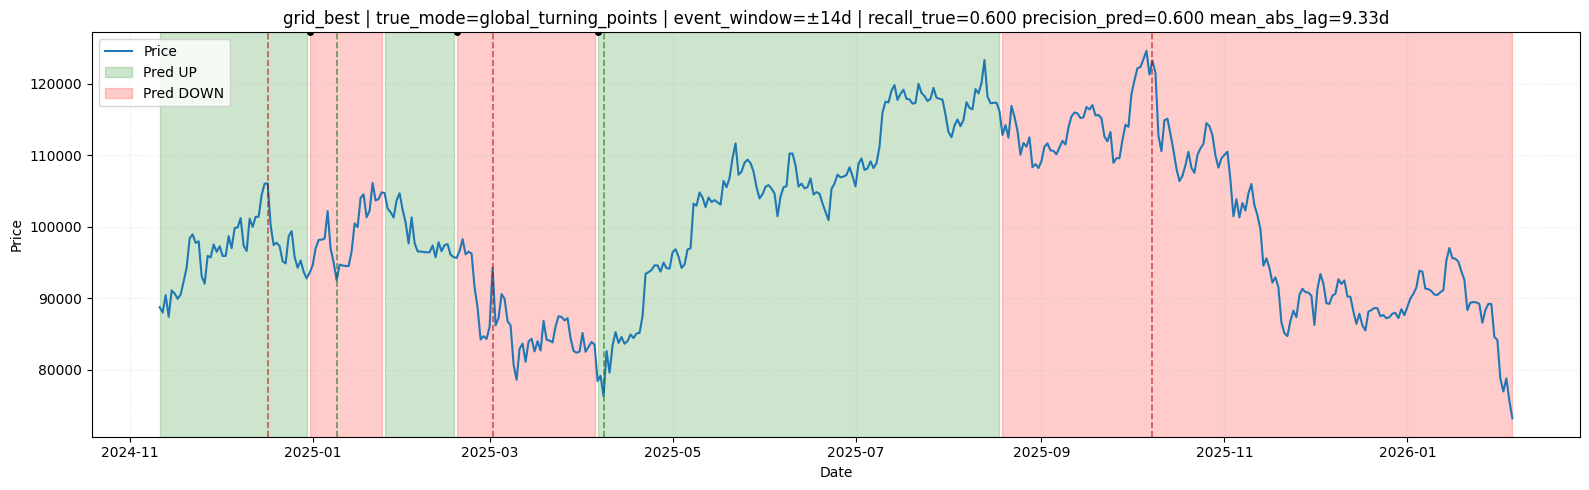

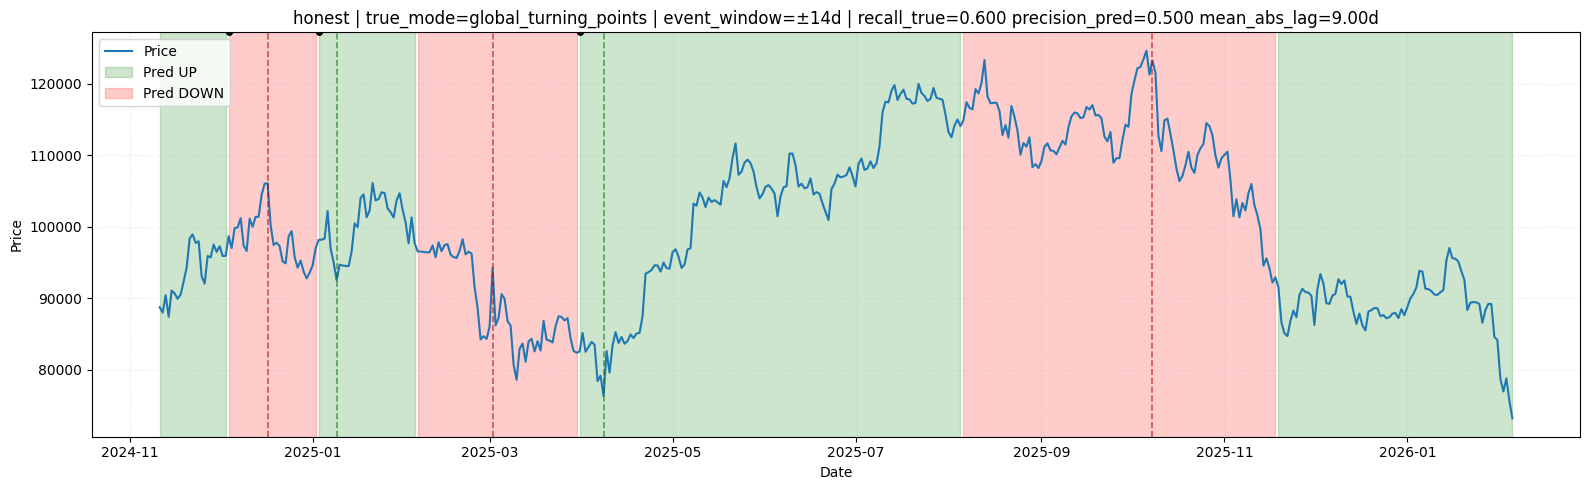

In [7]:
PLOT_WINDOW = 14
for tag, res in eval_results.items():
    plot_event_alignment(
        eval_result=res,
        window_days=PLOT_WINDOW,
        title_prefix=f"{tag}",
        price_color="#1f77b4",
        up_color="green",
        down_color="red",
        shade_alpha=0.20,
        show_block=PLOT_BLOCKING,
    )


In [8]:
print("Statistical conclusion summary:")

for tag in sorted(eval_results.keys()):
    cls = df_candidate_summary[df_candidate_summary["candidate"] == tag].iloc[0]
    evt = df_event_stats[df_event_stats["candidate"] == tag].sort_values(["p_shift_recall_bonf", "window_days"]).iloc[0]

    print("\n" + "=" * 90)
    print(f"Candidate: {tag}")
    print("Classification significance:")
    print(
        f"  accuracy p-value vs random = {float(cls['acc_p_value_vs_random']):.6g}, "
        f"95% CI = [{float(cls['acc_ci95_low']):.3f}, {float(cls['acc_ci95_high']):.3f}]"
    )
    print(
        f"  test_recall_min = {float(cls['test_recall_min']):.3f}, "
        f"test_recall_gap = {float(cls['test_recall_gap']):.3f}, "
        f"test_profit_y_obj = {float(cls['test_profit_y_obj']):+.6f}"
    )

    print("Event-time alignment significance (best window by corrected p):")
    print(
        f"  window = ±{int(evt['window_days'])}d, recall_true = {float(evt['recall_true']):.3f}, "
        f"precision_pred = {float(evt['precision_pred']):.3f}, mean_abs_lag = {float(evt['mean_abs_lag_days']):.2f}d"
    )
    print(
        f"  circular-shift p(recall) = {float(evt['p_shift_recall']):.6g}, "
        f"Bonferroni corrected = {float(evt['p_shift_recall_bonf']):.6g} "
        f"(family={int(evt['family_size_correction'])})"
    )

    if np.isfinite(evt["p_shift_recall_bonf"]) and float(evt["p_shift_recall_bonf"]) < 0.05:
        print("  Verdict: temporal alignment is statistically significant even after conservative correction.")
    elif np.isfinite(evt["p_shift_recall"]) and float(evt["p_shift_recall"]) < 0.05:
        print("  Verdict: raw significance exists, but conservative correction removes formal significance.")
    else:
        print("  Verdict: no strong event-time significance under current conservative test.")


Statistical conclusion summary:

Candidate: grid_best
Classification significance:
  accuracy p-value vs random = 0.0268377, 95% CI = [0.500, 0.592]
  test_recall_min = 0.536, test_recall_gap = 0.464, test_profit_y_obj = +0.012272
Event-time alignment significance (best window by corrected p):
  window = ±3d, recall_true = 0.200, precision_pred = 0.200, mean_abs_lag = 2.00d
  circular-shift p(recall) = 0.196903, Bonferroni corrected = 1 (family=1200)
  Verdict: no strong event-time significance under current conservative test.

Candidate: honest
Classification significance:
  accuracy p-value vs random = 1.26138e-18, 95% CI = [0.660, 0.744]
  test_recall_min = 0.702, test_recall_gap = 0.002, test_profit_y_obj = +0.008167
Event-time alignment significance (best window by corrected p):
  window = ±3d, recall_true = 0.000, precision_pred = 0.000, mean_abs_lag = nand
  circular-shift p(recall) = 1, Bonferroni corrected = 1 (family=24)
  Verdict: no strong event-time significance under curr

## What Dashed Vertical Lines Mean

- Dashed lines now represent **coarse market regime switches** (`TRUE_EVENT_MODE=market_smooth_regime`).
- Market truth is built from smoothed `next_ret` with hysteresis + minimum segment length (~monthly scale), not raw daily flips.
- Green dashed line: switch to UP regime, red dashed line: switch to DOWN regime.
- Predicted regime for event-tests is also smoothed from `proba_up` (`PRED_EVENT_MODE=proba_smooth_regime`).
- Matching tolerance is tested across broader windows (up to 1-2 weeks and beyond).


In [9]:
# Sweep broader radii for already evaluated candidates (grid_best/honest).
RADIUS_SWEEP_DAYS = [1, 2, 3, 4, 5, 6, 7, 10, 14, 21, 28]

wide_rows = []
for tag, res in eval_results.items():
    frame = res["test_frame"].copy().reset_index(drop=True)
    frame["date"] = pd.to_datetime(frame["date"])

    true_events = build_true_turn_events(
        eval_result=res,
        mode=TRUE_EVENT_MODE,
        min_move_pct=TRUE_EVENT_MIN_MOVE_PCT,
        min_segment_days=TRUE_EVENT_MIN_SEGMENT_DAYS,
        smooth_span_days=TRUE_EVENT_SMOOTH_SPAN_DAYS,
        enter_up=TRUE_EVENT_ENTER_UP,
        enter_down=TRUE_EVENT_ENTER_DOWN,
        df_market_ref=df_market,
        tp_horizon_days=TRUE_TP_HORIZON_DAYS,
        tp_up_move_pct=TRUE_TP_UP_MOVE_PCT,
        tp_down_move_pct=TRUE_TP_DOWN_MOVE_PCT,
        tp_cluster_gap_days=TRUE_TP_CLUSTER_GAP_DAYS,
        tp_min_turn_gap_days=TRUE_TP_MIN_TURN_GAP_DAYS,
        tp_past_horizon_days=TRUE_TP_PAST_HORIZON_DAYS,
        tp_past_up_move_pct=TRUE_TP_PAST_UP_MOVE_PCT,
        tp_past_down_move_pct=TRUE_TP_PAST_DOWN_MOVE_PCT,
        tp_tail_direction_mode=TRUE_TP_TAIL_DIRECTION_MODE,
        tp_tail_min_move_pct=TRUE_TP_TAIL_MIN_MOVE_PCT,
    )
    pred_labels = build_pred_regime_labels_from_frame(
        test_frame=frame,
        mode=PRED_EVENT_MODE,
        smooth_span_days=PRED_EVENT_SMOOTH_SPAN_DAYS,
        enter_up=PRED_EVENT_ENTER_UP,
        enter_down=PRED_EVENT_ENTER_DOWN,
        min_segment_days=PRED_EVENT_MIN_SEGMENT_DAYS,
    )

    for w in RADIUS_SWEEP_DAYS:
        perm = circular_shift_permutation_test(
            dates=frame["date"],
            pred_labels=pred_labels,
            true_events=true_events,
            window_days=int(w),
        )
        obs = perm["obs"]
        fam = int(candidate_family_size.get(tag, len(df_results)))
        wide_rows.append({
            "candidate": tag,
            "window_days": int(w),
            "n_true_events": int(obs["n_true_events"]),
            "n_pred_events": int(obs["n_pred_events"]),
            "n_matched": int(obs["n_matched"]),
            "recall_true": obs["recall_true"],
            "precision_pred": obs["precision_pred"],
            "f1_event": obs["f1_event"],
            "mean_abs_lag_days": obs["mean_abs_lag_days"],
            "p_shift_recall": perm["p_recall"],
            "p_shift_recall_bonf": bonferroni_correction(perm["p_recall"], fam),
            "null_recall_mean": perm["null_recall_mean"],
            "delta_recall_vs_null": (obs["recall_true"] - perm["null_recall_mean"]) if (np.isfinite(obs["recall_true"]) and np.isfinite(perm["null_recall_mean"])) else np.nan,
        })

df_radius_sweep_two = pd.DataFrame(wide_rows).sort_values(["candidate", "window_days"]).reset_index(drop=True)
print("Broader radius sweep for grid_best/honest:")
display(df_radius_sweep_two)

for tag in sorted(df_radius_sweep_two["candidate"].unique()):
    sub = df_radius_sweep_two[df_radius_sweep_two["candidate"] == tag].copy()
    best = sub.sort_values(["p_shift_recall_bonf", "window_days"]).iloc[0]
    print(f"[{tag}] best radius by corrected p: ±{int(best['window_days'])}d | recall={float(best['recall_true']):.3f} | p_bonf={float(best['p_shift_recall_bonf']):.6g}")

Broader radius sweep for grid_best/honest:


,candidate,window_days,n_true_events,n_pred_events,n_matched,recall_true,precision_pred,f1_event,mean_abs_lag_days,p_shift_recall,p_shift_recall_bonf,null_recall_mean,delta_recall_vs_null
0,grid_best,1,5,5,0,0.0,0.000000,NaN,NaN,1.000000,1.0,0.019956,-0.019956
1,grid_best,2,5,5,1,0.2,0.200000,0.200000,2.000000,0.143805,1.0,0.032816,0.167184
2,grid_best,3,5,5,1,0.2,0.200000,0.200000,2.000000,0.196903,1.0,0.046120,0.153880
3,grid_best,4,5,5,1,0.2,0.200000,0.200000,2.000000,0.250000,1.0,0.059424,0.140576
4,grid_best,5,5,5,1,0.2,0.200000,0.200000,2.000000,0.296460,1.0,0.072727,0.127273
5,grid_best,6,5,5,1,0.2,0.200000,0.200000,2.000000,0.338496,1.0,0.086031,0.113969
6,grid_best,7,5,5,1,0.2,0.200000,0.200000,2.000000,0.378319,1.0,0.099335,0.100665
7,grid_best,10,5,5,1,0.2,0.200000,0.200000,2.000000,0.486726,1.0,0.139246,0.060754
8,grid_best,14,5,5,3,0.6,0.600000,0.600000,9.333333,0.088496,1.0,0.191574,0.408426
9,grid_best,21,5,5,4,0.8,0.800000,0.800000,11.000000,0.077434,1.0,0.284257,0.515743


[grid_best] best radius by corrected p: ±1d | recall=0.000 | p_bonf=1
[honest] best radius by corrected p: ±1d | recall=0.000 | p_bonf=1


In [10]:
import time
from datetime import timedelta

TOP_N = 100
TOP_POOL = "feasible"  # "feasible" or "all"
TOP_WINDOW_SWEEP = [1, 2, 3, 4, 5, 6, 7, 10, 14, 21, 28]
RUN_TOP100_NOW = True

EVENT_STATS_TAG = (
    f"true-{TRUE_EVENT_MODE}_pred-{PRED_EVENT_MODE}"
    f"_tp{int(round(TRUE_TP_UP_MOVE_PCT * 100.0))}"
    f"_gap{int(TRUE_TP_MIN_TURN_GAP_DAYS)}"
    f"_seg{int(PRED_EVENT_MIN_SEGMENT_DAYS)}"
).replace(".", "p")
TOP_STATS_PATH = Path(REPORTS_DIR) / f"{RUN_TAG}_top{TOP_N}_event_stats_{EVENT_STATS_TAG}.csv"


def _select_top_candidates(df_sorted: pd.DataFrame, top_n: int, pool: str = "feasible") -> pd.DataFrame:
    if str(pool).lower() == "feasible":
        d = df_sorted[df_sorted.get("is_feasible", 0) == 1].copy()
        if d.empty:
            d = df_sorted.copy()
    else:
        d = df_sorted.copy()
    d = d.head(int(top_n)).copy().reset_index(drop=True)
    d["candidate_rank"] = np.arange(1, len(d) + 1, dtype=int)
    return d


def _candidate_key(row: pd.Series) -> str:
    rank = int(row.get("candidate_rank", -1))
    eval_id = int(row.get("eval_id", -1)) if np.isfinite(pd.to_numeric(row.get("eval_id", np.nan), errors="coerce")) else -1
    return f"rank{rank:03d}_eval{eval_id}"


def _eta_str(elapsed_sec: float, done: int, total: int) -> str:
    if done <= 0:
        return "?"
    left = max(0, int(total - done))
    per = elapsed_sec / max(1, done)
    eta = timedelta(seconds=int(per * left))
    return str(eta)


def evaluate_candidate_fast_topn(
    row: pd.Series,
    tag: str,
    df_market_local: pd.DataFrame,
    close_map_local: pd.DataFrame,
    feature_cache_local: dict[tuple[str, str, float], pd.DataFrame],
    seed: int = 42,
) -> Dict[str, Any]:
    """Fast path for top-N event sweep (skips bootstrap/significance extras)."""
    df_features = get_or_build_features_for_row(row=row, df_market=df_market_local, feature_cache=feature_cache_local)

    label_cfg = _extract_label_cfg(row)
    target_cfg = _extract_target_cfg(row)
    model_cfg = _extract_model_cfg(row)

    turn_cfg = TurningPointLabelConfig(
        horizon_days=int(row.get("horizon_days_fixed", 10)),
        up_move_pct=float(label_cfg["up_move_pct"]),
        down_move_pct=float(label_cfg["down_move_pct"]),
        cluster_gap_days=int(label_cfg["cluster_gap_days"]),
        min_turn_gap_days=int(label_cfg["min_turn_gap_days"]),
        past_horizon_days=int(label_cfg["past_horizon_days"]),
        past_up_move_pct=float(label_cfg["past_up_move_pct"]),
        past_down_move_pct=float(label_cfg["past_down_move_pct"]),
        tail_direction_mode=str(row.get("tail_direction_mode_fixed", "endpoint_sign")),
        tail_min_move_pct=float(row.get("tail_min_move_pct_fixed", 0.0)),
    )

    _, df_turns, _ = label_turning_points(df_market=df_market_local, cfg=turn_cfg)

    if target_cfg["mode"] == "window_kernel":
        df_target = build_turning_target_frame(
            df_market=df_market_local,
            df_turning_points=df_turns,
            mode="window_kernel",
            window_radius_days=int(target_cfg["window_radius_days"]),
            window_distance_power=float(target_cfg["window_distance_power"]),
            min_weight=float(target_cfg["min_weight"]),
            use_amplitude_weight=bool(target_cfg["use_amplitude_weight"]),
            use_numba=True,
        )
    else:
        df_target = build_turning_target_frame(
            df_market=df_market_local,
            df_turning_points=df_turns,
            mode="segment_midpoint",
            segment_center_power=float(target_cfg["segment_center_power"]),
            segment_direction_anchor=str(target_cfg["segment_direction_anchor"]),
            include_last_open_segment=bool(target_cfg["include_last_open_segment"]),
            segment_open_tail_direction_mode=str(target_cfg["segment_open_tail_direction_mode"]),
            segment_open_tail_min_move_pct=float(target_cfg["segment_open_tail_min_move_pct"]),
            min_weight=float(target_cfg["min_weight"]),
            use_amplitude_weight=bool(target_cfg["use_amplitude_weight"]),
            use_numba=True,
        )

    df_dataset = merge_features_with_turning_target(
        df_features=df_features,
        df_target=df_target,
        df_market_close=df_market_local[["date", "close"]],
    )
    df_dataset = pd.merge(df_dataset, close_map_local[["date", "next_ret"]], on="date", how="left")
    df_dataset = (
        df_dataset
        .dropna(subset=["next_ret", "target", "sample_weight", "close"])
        .sort_values("date")
        .reset_index(drop=True)
    )

    split = make_classic_split(df_dataset, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO)
    train_df = df_dataset.iloc[split.train_idx].copy().reset_index(drop=True)
    val_df = df_dataset.iloc[split.val_idx].copy().reset_index(drop=True)
    test_df = df_dataset.iloc[split.test_idx].copy().reset_index(drop=True)

    feature_cols = [
        c for c in df_dataset.columns
        if c not in {
            "date", "target", "close", "next_ret",
            "turning_direction", "sample_weight", "target_mode",
            "event_index", "segment_index",
        }
    ]

    X_train = train_df[feature_cols].to_numpy(dtype=np.float32)
    y_train = train_df["target"].to_numpy(dtype=np.int32)
    X_val = val_df[feature_cols].to_numpy(dtype=np.float32)
    y_val = val_df["target"].to_numpy(dtype=np.int32)
    X_test = test_df[feature_cols].to_numpy(dtype=np.float32)
    y_test = test_df["target"].to_numpy(dtype=np.int32)

    sw_train_base = pd.to_numeric(train_df["sample_weight"], errors="coerce").fillna(1.0).to_numpy(dtype=np.float32)
    sw_val_base = pd.to_numeric(val_df["sample_weight"], errors="coerce").fillna(1.0).to_numpy(dtype=np.float32)
    sw_test_base = pd.to_numeric(test_df["sample_weight"], errors="coerce").fillna(1.0).to_numpy(dtype=np.float32)

    sw_train = sw_train_base * compute_sample_weight(class_weight="balanced", y=y_train).astype(np.float32)
    sw_val = sw_val_base * compute_sample_weight(class_weight="balanced", y=y_val).astype(np.float32)
    sw_test = sw_test_base * compute_sample_weight(class_weight="balanced", y=y_test).astype(np.float32)

    _, device = check_cuda_available()

    def _make_model(device_name: str) -> XGBBaseline:
        return XGBBaseline(
            n_classes=2,
            device=device_name,
            random_state=seed,
            early_stopping_rounds=int(model_cfg["early_stopping_rounds"]),
            n_estimators=int(model_cfg["n_estimators"]),
            max_depth=int(model_cfg["max_depth"]),
            learning_rate=float(model_cfg["learning_rate"]),
            subsample=float(model_cfg["subsample"]),
            colsample_bytree=float(model_cfg["colsample_bytree"]),
            tree_method="hist",
            eval_metric="logloss",
        )

    used_device = str(device)
    model = _make_model(used_device)
    try:
        model.fit(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            feature_names=feature_cols,
            sample_weight=sw_train,
            sample_weight_val=sw_val,
        )
    except Exception:
        used_device = "cpu"
        model = _make_model(used_device)
        model.fit(
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            feature_names=feature_cols,
            sample_weight=sw_train,
            sample_weight_val=sw_val,
        )

    threshold = float(row.get("threshold", 0.5))
    p_test = _safe_predict_proba_up(model, X_test)
    pred_test = (p_test >= threshold).astype(np.int32)
    test_metrics = compute_binary_metrics(y_test, pred_test)

    ret_test = pd.to_numeric(test_df["next_ret"], errors="coerce").fillna(0.0).to_numpy(dtype=np.float32)

    test_start = pd.to_datetime(test_df["date"].min())
    test_end = pd.to_datetime(test_df["date"].max())
    turns_test = df_turns[(pd.to_datetime(df_turns["date"]) >= test_start) & (pd.to_datetime(df_turns["date"]) <= test_end)].copy()

    out = {
        "tag": tag,
        "used_device": used_device,
        "threshold": threshold,
        "test_metrics": test_metrics,
        "test_profit_y": _profit_y(pred_test, ret_test),
        "test_profit_y_obj": _profit_y_obj(pred_test, ret_test, sw_test),
        "turns_test": turns_test[["date", "turning_direction"]].copy(),
        "test_frame": test_df[["date", "close", "next_ret", "target"]].assign(
            pred=pred_test,
            proba_up=p_test,
            match=(pred_test == y_test).astype(np.int32),
        ),
    }
    return out


def run_topn_event_sweep(
    df_sorted: pd.DataFrame,
    df_market_local: pd.DataFrame,
    close_map_local: pd.DataFrame,
    feature_cache_local: dict[tuple[str, str, float], pd.DataFrame],
    top_n: int = 100,
    pool: str = "feasible",
    windows: list[int] | None = None,
    out_path: Path | None = None,
) -> pd.DataFrame:
    ws = windows or [1, 2, 3, 5, 7]
    out_path = out_path or TOP_STATS_PATH
    selected = _select_top_candidates(df_sorted, top_n=top_n, pool=pool)

    if out_path.exists():
        df_existing = pd.read_csv(out_path)
    else:
        df_existing = pd.DataFrame()

    done_keys = set(df_existing["candidate_key"].astype(str).tolist()) if not df_existing.empty and "candidate_key" in df_existing.columns else set()
    rows_acc = []

    t0 = time.time()
    total = len(selected)
    done = 0

    print(f"[TOP-N] selected={total} pool={pool} windows={ws}")
    if len(done_keys) > 0:
        print(f"[TOP-N] resume from checkpoint: {len(done_keys)} candidate(s) already done")

    for _, row in selected.iterrows():
        key = _candidate_key(row)
        if key in done_keys:
            done += 1
            continue

        tag = f"top{int(row['candidate_rank']):03d}"
        print(f"[TOP-N EVAL] {tag} key={key} ({done+1}/{total})")

        ev = evaluate_candidate_fast_topn(
            row=row,
            tag=tag,
            df_market_local=df_market_local,
            close_map_local=close_map_local,
            feature_cache_local=feature_cache_local,
            seed=SEED,
        )

        frame = ev["test_frame"].copy().reset_index(drop=True)
        frame["date"] = pd.to_datetime(frame["date"])
        true_events = build_true_turn_events(
            eval_result=ev,
            mode=TRUE_EVENT_MODE,
            min_move_pct=TRUE_EVENT_MIN_MOVE_PCT,
            min_segment_days=TRUE_EVENT_MIN_SEGMENT_DAYS,
            smooth_span_days=TRUE_EVENT_SMOOTH_SPAN_DAYS,
            enter_up=TRUE_EVENT_ENTER_UP,
            enter_down=TRUE_EVENT_ENTER_DOWN,
            df_market_ref=df_market_local,
            tp_horizon_days=TRUE_TP_HORIZON_DAYS,
            tp_up_move_pct=TRUE_TP_UP_MOVE_PCT,
            tp_down_move_pct=TRUE_TP_DOWN_MOVE_PCT,
            tp_cluster_gap_days=TRUE_TP_CLUSTER_GAP_DAYS,
            tp_min_turn_gap_days=TRUE_TP_MIN_TURN_GAP_DAYS,
            tp_past_horizon_days=TRUE_TP_PAST_HORIZON_DAYS,
            tp_past_up_move_pct=TRUE_TP_PAST_UP_MOVE_PCT,
            tp_past_down_move_pct=TRUE_TP_PAST_DOWN_MOVE_PCT,
            tp_tail_direction_mode=TRUE_TP_TAIL_DIRECTION_MODE,
            tp_tail_min_move_pct=TRUE_TP_TAIL_MIN_MOVE_PCT,
        )
        pred_labels = build_pred_regime_labels_from_frame(
            test_frame=frame,
            mode=PRED_EVENT_MODE,
            smooth_span_days=PRED_EVENT_SMOOTH_SPAN_DAYS,
            enter_up=PRED_EVENT_ENTER_UP,
            enter_down=PRED_EVENT_ENTER_DOWN,
            min_segment_days=PRED_EVENT_MIN_SEGMENT_DAYS,
        )
        family_within = len(ws)

        for w in ws:
            perm = circular_shift_permutation_test(
                dates=frame["date"],
                pred_labels=pred_labels,
                true_events=true_events,
                window_days=int(w),
            )
            obs = perm["obs"]
            p_raw = perm["p_recall"]

            rows_acc.append({
                "candidate_key": key,
                "candidate_rank": int(row["candidate_rank"]),
                "eval_id": int(row.get("eval_id", -1)) if np.isfinite(pd.to_numeric(row.get("eval_id", np.nan), errors="coerce")) else -1,
                "window_days": int(w),
                "test_profit_y_obj": float(ev["test_profit_y_obj"]),
                "test_profit_y": float(ev["test_profit_y"]),
                "test_recall_min": float(ev["test_metrics"]["recall_min"]),
                "test_recall_gap": float(ev["test_metrics"]["recall_gap"]),
                "test_mcc": float(ev["test_metrics"]["mcc"]),
                "n_true_events": int(obs["n_true_events"]),
                "n_pred_events": int(obs["n_pred_events"]),
                "n_matched": int(obs["n_matched"]),
                "recall_true": obs["recall_true"],
                "precision_pred": obs["precision_pred"],
                "f1_event": obs["f1_event"],
                "mean_abs_lag_days": obs["mean_abs_lag_days"],
                "p_shift_recall": p_raw,
                "p_shift_recall_within_bonf": bonferroni_correction(p_raw, family_within),
                "null_recall_mean": perm["null_recall_mean"],
                "null_recall_std": perm["null_recall_std"],
                "delta_recall_vs_null": (obs["recall_true"] - perm["null_recall_mean"]) if (np.isfinite(obs["recall_true"]) and np.isfinite(perm["null_recall_mean"])) else np.nan,
                "n_permutations": int(perm["n_permutations"]),
            })

        done += 1
        elapsed = time.time() - t0
        speed = done / max(1e-9, elapsed)
        print(f"[TOP-N PROGRESS] done={done}/{total} elapsed={timedelta(seconds=int(elapsed))} eta~{_eta_str(elapsed, done, total)} speed={speed:.3f}/s")

        # checkpoint after every candidate
        if len(rows_acc) > 0:
            df_new = pd.DataFrame(rows_acc)
            if df_existing.empty:
                df_existing = df_new.copy()
            else:
                df_existing = pd.concat([df_existing, df_new], ignore_index=True)
            rows_acc = []
            df_existing.to_csv(out_path, index=False)
            print(f"[TOP-N CHECKPOINT] {out_path} rows={len(df_existing)}")

    if len(rows_acc) > 0:
        df_new = pd.DataFrame(rows_acc)
        if df_existing.empty:
            df_existing = df_new.copy()
        else:
            df_existing = pd.concat([df_existing, df_new], ignore_index=True)
        df_existing.to_csv(out_path, index=False)

    return df_existing


def bh_fdr(p_values: np.ndarray) -> np.ndarray:
    p = np.asarray(p_values, dtype=float)
    n = len(p)
    out = np.full(n, np.nan, dtype=float)
    mask = np.isfinite(p)
    idx = np.where(mask)[0]
    if idx.size == 0:
        return out
    pv = p[idx]
    order = np.argsort(pv)
    ranked = pv[order]
    m = len(ranked)
    q = np.empty(m, dtype=float)
    q[-1] = ranked[-1]
    for i in range(m - 2, -1, -1):
        q[i] = min(q[i + 1], ranked[i] * m / (i + 1))
    q = np.clip(q, 0.0, 1.0)
    unsorted = np.empty(m, dtype=float)
    unsorted[order] = q
    out[idx] = unsorted
    return out


def safe_binomtest_greater(k: int, n: int, p0: float = 0.05) -> float:
    if n <= 0:
        return np.nan
    try:
        from scipy.stats import binomtest  # type: ignore
        return float(binomtest(k=k, n=n, p=p0, alternative="greater").pvalue)
    except Exception:
        # fallback Monte-Carlo approximation
        rng = np.random.default_rng(42)
        sims = rng.binomial(n=n, p=p0, size=50000)
        return float((1 + np.sum(sims >= k)) / (1 + len(sims)))


def safe_fisher_method(p_values: np.ndarray) -> float:
    pv = np.asarray(p_values, dtype=float)
    pv = pv[np.isfinite(pv)]
    pv = np.clip(pv, 1e-15, 1.0)
    if pv.size == 0:
        return np.nan
    try:
        from scipy.stats import combine_pvalues  # type: ignore
        _, p = combine_pvalues(pv, method="fisher")
        return float(p)
    except Exception:
        stat = -2.0 * float(np.sum(np.log(pv)))
        # rough fallback: return NaN if scipy unavailable
        return np.nan


if RUN_TOP100_NOW:
    df_top100_stats = run_topn_event_sweep(
        df_sorted=df_results,
        df_market_local=df_market,
        close_map_local=close_map,
        feature_cache_local=feature_cache,
        top_n=TOP_N,
        pool=TOP_POOL,
        windows=TOP_WINDOW_SWEEP,
        out_path=TOP_STATS_PATH,
    )
else:
    if TOP_STATS_PATH.exists():
        df_top100_stats = pd.read_csv(TOP_STATS_PATH)
    else:
        raise FileNotFoundError(f"Top-N stats file not found: {TOP_STATS_PATH}. Set RUN_TOP100_NOW=True to compute.")

print(f"Top-N stats rows: {len(df_top100_stats)}")
display(df_top100_stats.head(20))


[TOP-N] selected=100 pool=feasible windows=[1, 2, 3, 4, 5, 6, 7, 10, 14, 21, 28]
[TOP-N EVAL] top001 key=rank001_eval7795 (1/100)
[TOP-N PROGRESS] done=1/100 elapsed=0:00:11 eta~0:18:59 speed=0.087/s
[TOP-N CHECKPOINT] /home/rut/ostrofun/data/market/reports/turning_massive_label_grid_top100_event_stats_true-global_turning_points_pred-hard_label_tp9_gap14_seg10.csv rows=11
[TOP-N EVAL] top002 key=rank002_eval2544 (2/100)
[TOP-N PROGRESS] done=2/100 elapsed=0:00:21 eta~0:17:32 speed=0.093/s
[TOP-N CHECKPOINT] /home/rut/ostrofun/data/market/reports/turning_massive_label_grid_top100_event_stats_true-global_turning_points_pred-hard_label_tp9_gap14_seg10.csv rows=22
[TOP-N EVAL] top003 key=rank003_eval9538 (3/100)
[TOP-N PROGRESS] done=3/100 elapsed=0:00:33 eta~0:18:10 speed=0.089/s
[TOP-N CHECKPOINT] /home/rut/ostrofun/data/market/reports/turning_massive_label_grid_top100_event_stats_true-global_turning_points_pred-hard_label_tp9_gap14_seg10.csv rows=33
[TOP-N EVAL] top004 key=rank004_eval4

,candidate_key,candidate_rank,eval_id,window_days,test_profit_y_obj,test_profit_y,test_recall_min,test_recall_gap,test_mcc,n_true_events,n_pred_events,n_matched,recall_true,precision_pred,f1_event,mean_abs_lag_days,p_shift_recall,p_shift_recall_within_bonf,null_recall_mean,null_recall_std,delta_recall_vs_null,n_permutations
0,rank001_eval7795,1,7795,1,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,0,0.0,0.0,NaN,NaN,1.000000,1.000000,0.019956,0.065593,-0.019956,451
1,rank001_eval7795,1,7795,2,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,1,0.2,0.2,0.2,2.000000,0.143805,1.000000,0.032816,0.085206,0.167184,451
2,rank001_eval7795,1,7795,3,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,1,0.2,0.2,0.2,2.000000,0.196903,1.000000,0.046120,0.099675,0.153880,451
3,rank001_eval7795,1,7795,4,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,1,0.2,0.2,0.2,2.000000,0.250000,1.000000,0.059424,0.110707,0.140576,451
4,rank001_eval7795,1,7795,5,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,1,0.2,0.2,0.2,2.000000,0.296460,1.000000,0.072727,0.121471,0.127273,451
5,rank001_eval7795,1,7795,6,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,1,0.2,0.2,0.2,2.000000,0.338496,1.000000,0.086031,0.132702,0.113969,451
6,rank001_eval7795,1,7795,7,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,1,0.2,0.2,0.2,2.000000,0.378319,1.000000,0.099335,0.143057,0.100665,451
7,rank001_eval7795,1,7795,10,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,1,0.2,0.2,0.2,2.000000,0.486726,1.000000,0.139246,0.169879,0.060754,451
8,rank001_eval7795,1,7795,14,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,3,0.6,0.6,0.6,9.333333,0.088496,0.973451,0.191574,0.197591,0.408426,451
9,rank001_eval7795,1,7795,21,0.012272,0.002161,0.536199,0.463801,0.157922,5,5,4,0.8,0.8,0.8,11.000000,0.077434,0.851770,0.284257,0.226014,0.515743,451


In [11]:
# Global statistical summary over top-100 candidates.

df_top = df_top100_stats.copy()
if df_top.empty:
    raise ValueError("Top-N stats are empty")

# Per-window aggregate (does a wider radius improve event-time signal?).
agg_window = df_top.groupby("window_days", as_index=False).agg(
    n_rows=("candidate_key", "count"),
    n_candidates=("candidate_key", pd.Series.nunique),
    mean_recall_true=("recall_true", "mean"),
    mean_null_recall=("null_recall_mean", "mean"),
    mean_delta_recall=("delta_recall_vs_null", "mean"),
    median_delta_recall=("delta_recall_vs_null", "median"),
    share_delta_pos=("delta_recall_vs_null", lambda x: float(np.mean(pd.to_numeric(x, errors="coerce") > 0.0))),
    share_raw_p_lt_005=("p_shift_recall", lambda x: float(np.mean(pd.to_numeric(x, errors="coerce") < 0.05))),
)
agg_window = agg_window.sort_values("window_days").reset_index(drop=True)
print("Per-window aggregate:")
display(agg_window)

# Candidate-level best window by smallest within-candidate Bonferroni p.
cand_best = (
    df_top.sort_values(["candidate_key", "p_shift_recall_within_bonf", "window_days"])
    .groupby("candidate_key", as_index=False)
    .head(1)
    .reset_index(drop=True)
)
cand_best["q_bh_across_candidates"] = bh_fdr(cand_best["p_shift_recall_within_bonf"].to_numpy(dtype=float))

n_cand = int(cand_best["candidate_key"].nunique())
k_raw = int(np.sum(pd.to_numeric(cand_best["p_shift_recall_within_bonf"], errors="coerce") < 0.05))
k_fdr = int(np.sum(pd.to_numeric(cand_best["q_bh_across_candidates"], errors="coerce") < 0.10))

p_binom = safe_binomtest_greater(k=k_raw, n=n_cand, p0=0.05)
p_fisher = safe_fisher_method(cand_best["p_shift_recall_within_bonf"].to_numpy(dtype=float))

mean_delta = float(pd.to_numeric(cand_best["delta_recall_vs_null"], errors="coerce").mean())
share_delta_pos = float(np.mean(pd.to_numeric(cand_best["delta_recall_vs_null"], errors="coerce") > 0.0))

best_window_row = agg_window.sort_values(["mean_delta_recall", "share_raw_p_lt_005"], ascending=[False, False]).iloc[0]
best_window = int(best_window_row["window_days"])

print("\nGlobal inference summary (Top-N):")
print(f"  candidates analyzed: {n_cand}")
print(f"  raw significant candidates (p_within<0.05): {k_raw}/{n_cand}")
print(f"  FDR significant candidates (q<0.10): {k_fdr}/{n_cand}")
print(f"  binomial p-value for excess significant candidates vs 5% null: {p_binom:.6g}")
print(f"  Fisher combined p-value (candidate best-window p-values): {p_fisher:.6g}")
print(f"  mean delta recall vs null at candidate-best windows: {mean_delta:+.4f}")
print(f"  share(delta_recall_vs_null > 0): {share_delta_pos:.3f}")
print(f"  empirically best radius (by aggregate delta recall): ±{best_window} days")

display(cand_best.sort_values(["p_shift_recall_within_bonf", "q_bh_across_candidates"]).head(30))

if np.isfinite(p_binom) and p_binom < 0.05:
    print("\nVerdict: there is aggregate statistical evidence that astro-only models align with real regime-switch timing above null.")
else:
    print("\nVerdict: under this conservative test, aggregate timing dependence is not yet statistically proven.")


Per-window aggregate:


,window_days,n_rows,n_candidates,mean_recall_true,mean_null_recall,mean_delta_recall,median_delta_recall,share_delta_pos,share_raw_p_lt_005
0,1,100,100,0.035857,0.021173,0.014684,-0.019956,0.19,0.00
1,2,100,100,0.057286,0.035259,0.022027,-0.022173,0.30,0.00
2,3,100,100,0.071964,0.049265,0.022699,-0.031042,0.36,0.01
3,4,100,100,0.077060,0.063381,0.013678,-0.029310,0.38,0.01
4,5,100,100,0.077060,0.077307,-0.000247,-0.035736,0.36,0.01
5,6,100,100,0.089988,0.091209,-0.001221,-0.035839,0.38,0.00
6,7,100,100,0.089988,0.103608,-0.013620,-0.047302,0.38,0.00
7,10,100,100,0.112524,0.138175,-0.025651,-0.042953,0.41,0.00
8,14,100,100,0.160619,0.179778,-0.019159,0.000000,0.49,0.00
9,21,100,100,0.227361,0.251960,-0.024599,-0.036773,0.42,0.00



Global inference summary (Top-N):
  candidates analyzed: 100
  raw significant candidates (p_within<0.05): 0/100
  FDR significant candidates (q<0.10): 0/100
  binomial p-value for excess significant candidates vs 5% null: 1
  Fisher combined p-value (candidate best-window p-values): 1
  mean delta recall vs null at candidate-best windows: +0.0358
  share(delta_recall_vs_null > 0): 0.240
  empirically best radius (by aggregate delta recall): ±3 days


,candidate_key,candidate_rank,eval_id,window_days,test_profit_y_obj,test_profit_y,test_recall_min,test_recall_gap,test_mcc,n_true_events,n_pred_events,n_matched,recall_true,precision_pred,f1_event,mean_abs_lag_days,p_shift_recall,p_shift_recall_within_bonf,null_recall_mean,null_recall_std,delta_recall_vs_null,n_permutations,q_bh_across_candidates
15,rank016_eval2233,16,2233,3,0.010058,0.001688,0.496063,0.150402,0.142692,5,5,2,0.4,0.400000,0.400000,2.5,0.013274,0.146018,0.045676,0.089083,0.354324,451,1.0
60,rank061_eval4724,61,4724,21,0.005069,0.001749,0.384615,0.314414,0.082893,5,3,3,0.6,1.000000,0.750000,12.0,0.055310,0.608407,0.189357,0.173837,0.410643,451,1.0
24,rank025_eval7279,25,7279,1,0.017109,0.002863,0.530364,0.391587,0.480683,5,3,1,0.2,0.333333,0.250000,0.0,0.066372,0.730088,0.012860,0.049058,0.187140,451,1.0
33,rank034_eval1603,34,1603,1,0.008446,0.000602,0.354331,0.328746,0.035829,5,4,1,0.2,0.250000,0.222222,1.0,0.066372,0.730088,0.012860,0.049058,0.187140,451,1.0
44,rank045_eval9531,45,9531,1,0.008757,-0.000111,0.286822,0.620395,0.238535,5,4,1,0.2,0.250000,0.222222,1.0,0.066372,0.730088,0.012860,0.049058,0.187140,451,1.0
61,rank062_eval2555,62,2555,1,0.007883,0.001918,0.609524,0.142301,0.332149,5,4,1,0.2,0.250000,0.222222,0.0,0.066372,0.730088,0.012860,0.049058,0.187140,451,1.0
66,rank067_eval2851,67,2851,1,0.008165,0.000548,0.389163,0.329713,0.114317,5,4,1,0.2,0.250000,0.222222,1.0,0.066372,0.730088,0.012860,0.049058,0.187140,451,1.0
68,rank069_eval563,69,563,1,0.007873,0.000602,0.389163,0.333729,0.118770,5,4,1,0.2,0.250000,0.222222,1.0,0.066372,0.730088,0.012860,0.049058,0.187140,451,1.0
35,rank036_eval2291,36,2291,28,0.011268,0.001957,0.560870,0.051743,0.173661,5,3,3,0.6,1.000000,0.750000,19.0,0.070796,0.778761,0.251441,0.168511,0.348559,451,1.0
5,rank006_eval9471,6,9471,6,0.008255,0.003048,0.475113,0.524887,0.140117,5,5,2,0.4,0.400000,0.400000,4.0,0.073009,0.803097,0.085588,0.129952,0.314412,451,1.0



Verdict: under this conservative test, aggregate timing dependence is not yet statistically proven.
